In [2]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

from hypnotoad import tokamak
from hypnotoad.core.mesh import BoutMesh
from fusiondls import run_dls, file_read, file_write
from fusiondls.unpackConfigurationsMK import unpackConfigurationMK
from fusiondls.AnalyticCoolingCurves import LfuncKallenbach
from fusiondls.Profile import Profile


onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *

from code_comparison.solps_pp import *

from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline

%load_ext autoreload
%autoreload 2

def seed_label(string):
    number = (float(string.split("_")[1]))
    out = fr"$\Gamma_{{N}}={number:.0f} \times 10^{{21}}s^{{-1}}$"
    return out



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IO

In [3]:
balance_paths = {
    "seed_1" : r"C:\Users\mikek\OneDrive\Project\DLS\from_omkar\seeding\seed_1",
    "seed_2" : r"C:\Users\mikek\OneDrive\Project\DLS\from_omkar\seeding\seed_2",
    "seed_3" : r"C:\Users\mikek\OneDrive\Project\DLS\from_omkar\seeding\seed_3",
    "seed_4" : r"C:\Users\mikek\OneDrive\Project\DLS\from_omkar\seeding\seed_4",
    "seed_5" : r"C:\Users\mikek\OneDrive\Project\DLS\from_omkar\seeding\seed_5",
    "seed_6" : r"C:\Users\mikek\OneDrive\Project\DLS\from_omkar\seeding\seed_6",
    "seed_7" : r"C:\Users\mikek\OneDrive\Project\DLS\from_omkar\seeding\seed_7",
    "seed_8" : r"C:\Users\mikek\OneDrive\Project\DLS\from_omkar\seeding\seed_8",
    "seed_9" : r"C:\Users\mikek\OneDrive\Project\DLS\from_omkar\seeding\seed_9",
    "seed_10" : r"C:\Users\mikek\OneDrive\Project\DLS\from_omkar\seeding\seed_10",    
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_impurity_stats("N", all_states = True)
        store_slc[case].get_impurity_stats("C", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")

seed_1
Warning, hy not found in balance file
Saving all states
Added total radiation, density and fraction for N
Saving all states
Added total radiation, density and fraction for C
seed_2
Warning, hy not found in balance file
Saving all states
Added total radiation, density and fraction for N
Saving all states
Added total radiation, density and fraction for C
seed_3
Warning, hy not found in balance file
Saving all states
Added total radiation, density and fraction for N
Saving all states
Added total radiation, density and fraction for C
seed_4
Warning, hy not found in balance file
Saving all states
Added total radiation, density and fraction for N
Saving all states
Added total radiation, density and fraction for C
seed_5
Warning, hy not found in balance file
Saving all states
Added total radiation, density and fraction for N
Saving all states
Added total radiation, density and fraction for C
seed_6
Warning, hy not found in balance file
Saving all states
Added total radiation, density a

# Prepare DLS geometry from SOLPS

In [4]:
eqb = dict()       # Geometry calculated using DLS built-in routines
eqb_alt = dict()   # Geometry calculated with my SOLPS post-processing routines

for case in balance_paths:
    print(case)
    eqb[case] = dict()
    eqb_alt[case] = dict()
    for region in ["outer_lower", "inner_lower", "outer_upper", "inner_upper"]:
        eqb[case][region] = dict()
        eqb_alt[case][region] = dict()
        for i in range(10):
            # eqb[case][side][i] = unpackConfigurationMK(
            #     File = os.path.join(balance_paths[case], "balance.nc"), Type = side, sepadd=i, 
            #     resolution = 500, diagnostic_plot = False)
            
            
            df = store_slc[case].get_1d_poloidal_data(["R", "Z", "Btot", "Bpol"], 
                                                      region = region, sepadd = i,
                                                      target_first = True).reset_index(drop = True)
            
            params = {}
            
            for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
                params[key] = np.array(df[key].values)

            eqb_alt[case][region][i] = Profile(params["R"], params["Z"], df[df["Xpoint"]==1].index[0], params["Btot"], params["Bpol"], params["Spar"], params["Spol"], name = "outer_lower_sepadd1")
    

seed_1
seed_2
seed_3
seed_4
seed_5
seed_6
seed_7
seed_8
seed_9
seed_10


# Cooling curve work

In [5]:
rd_N = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\nitrogen.nc")
rd_Ar = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc")

## ADAS interpolation

Text(0.5, 1.0, 'Interpolated N curves')

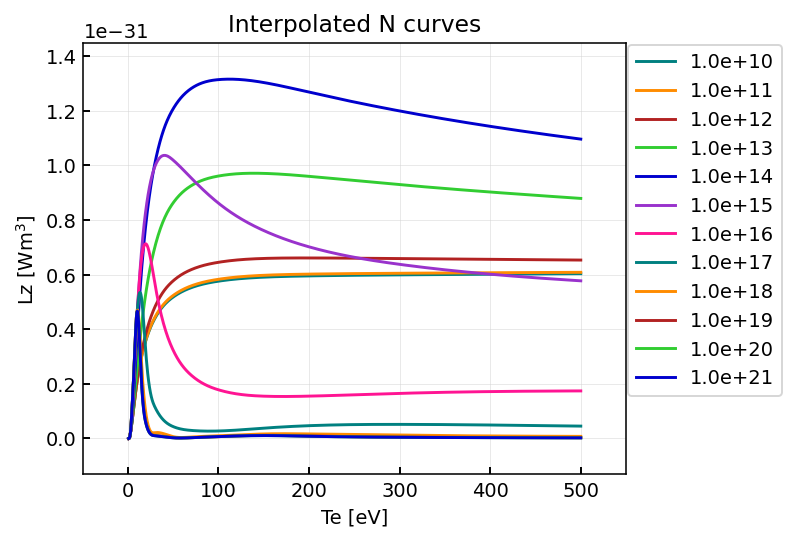

In [6]:
curves = {}
curves["N"] = {}

for netau in rd_N.coords["dim_ne_tau"].values:
    rate = rd_N["equilibrium_Lz"].sel(dim_ne_tau = netau, dim_electron_density=1e20, method="nearest")
    netau_name = netau
    curves["N"][netau_name] = sp.interpolate.interp1d(
        rd_N.coords["dim_electron_temp"].values, rate.values, kind = "cubic",
        fill_value = (rate.values[0], rate.values[-1]), bounds_error = False
        )

temps_interp = np.linspace(1, 500, 1000)

fig, ax = plt.subplots()
for netau in curves["N"].keys():
    ax.plot(temps_interp, [curves["N"][netau](T) for T in temps_interp], label = f"{netau:.1e}")
    
ax.legend(loc = "upper left", bbox_to_anchor=(1,1))
# ax.set_xlim(0,2)
# ax.set_ylim(0,1e-35)
# ax.set_yscale("log")
ax.set_xlabel("Te [eV]")
ax.set_ylabel("Lz [$Wm^{3}$]")
ax.set_title("Interpolated N curves")

## Compare effective curves

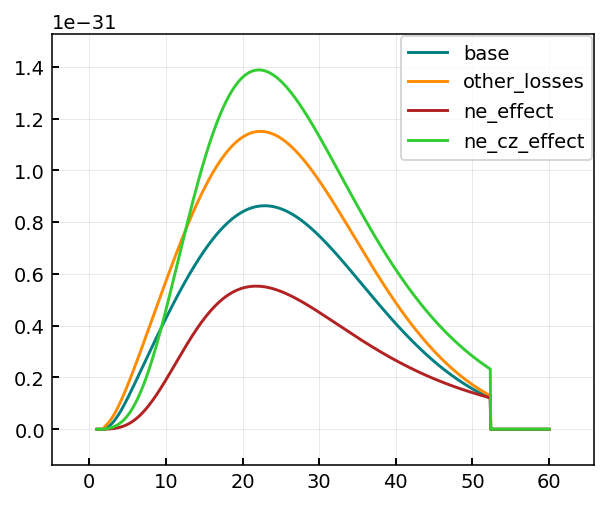

In [7]:
case = "seed_4"
slc = store_slc[case]
funs = {}
funs["base"] = slc.extract_cooling_curve("N", "outer_lower", sepadd = 4, order = 5, plot = False)
funs["other_losses"] = slc.extract_cooling_curve("N", "outer_lower", other_losses = True, sepadd = 4, order = 5, plot = False)
funs["ne_effect"] = slc.extract_cooling_curve("N", "outer_lower", other_losses = True, ne_effect = True, sepadd = 4, order = 5, plot = False)
funs["ne_cz_effect"] = slc.extract_cooling_curve("N", "outer_lower", other_losses = True, ne_effect = True, cz_effect = True, sepadd = 4, order = 5, plot = False)

temps = np.linspace(1, 60, 1000)
fig, ax = plt.subplots()

for fun in funs.keys():
    ax.plot(temps, [funs[fun](T) for T in temps], label = fun)
ax.legend()


## Compare to SOLPS

### Outer

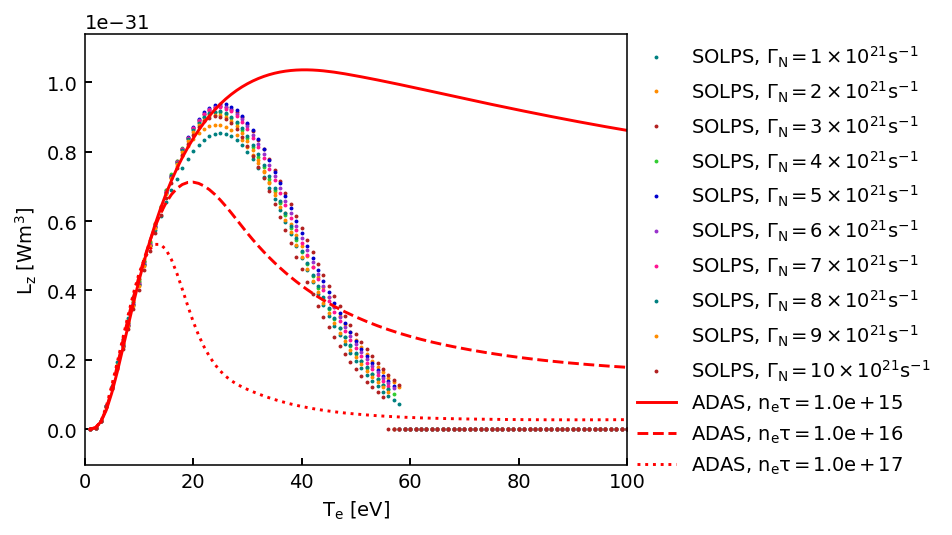

In [8]:
species = "N"
sepadd = 3
region = "outer_lower"

fig, ax = plt.subplots()

Tlo = 1
Thi = 500

T = np.linspace(Tlo, Thi, 500)

df_curves = []
for case in store_slc:
    slc = store_slc[case]
    fun = slc.extract_cooling_curve(species, region, sepadd = sepadd, order = 5, plot = False)

    Lz = [fun(temp) for temp in T]
    
    df_curve = pd.DataFrame()
    df_curve["T"] = T
    df_curve["Lz"] = Lz
    df_curves.append(df_curve)
    ax.plot(T, Lz, marker = "o", ms = 1, lw = 0, label = "SOLPS, "+seed_label(case))
    

allcurves = pd.concat(df_curves).sort_values("T")
allcurves = allcurves.groupby("T").mean().reset_index()
N_allcurvefit = sp.interpolate.interp1d(allcurves["T"], allcurves["Lz"], kind = "cubic")
N_allcurvefit = sp.interpolate.interp1d(allcurves["T"], allcurves["Lz"], kind = "cubic",
                                        fill_value = (N_allcurvefit(Tlo), N_allcurvefit(Thi)), bounds_error = False)
# ax.plot(T, [N_allcurvefit(temp) for temp in T], label = "SOLPS fit", c = "k", ls = "--", alpha = 1,  lw = 2)

linestyles = ["-", "--", ":"]

for i, netau in enumerate([1e15, 1e16, 1e17]):
    ax.plot(T, [curves["N"][netau](temp) for temp in T], label = rf"ADAS, $n_{{e}}\tau={netau:.1e}$", c = "r", ls = linestyles[i])
ax.legend(loc = "upper left", bbox_to_anchor=(1,1), frameon = False)
ax.set_xlim(0,100)
ax.set_xlabel("$T_e$ [eV]")
ax.set_ylabel("$L_{z}$ [$Wm^{3}$]")
ax.grid(which = "both", visible = False)
# ax.set_title("Cross-case Lz comparison to ADAS")

### Inner

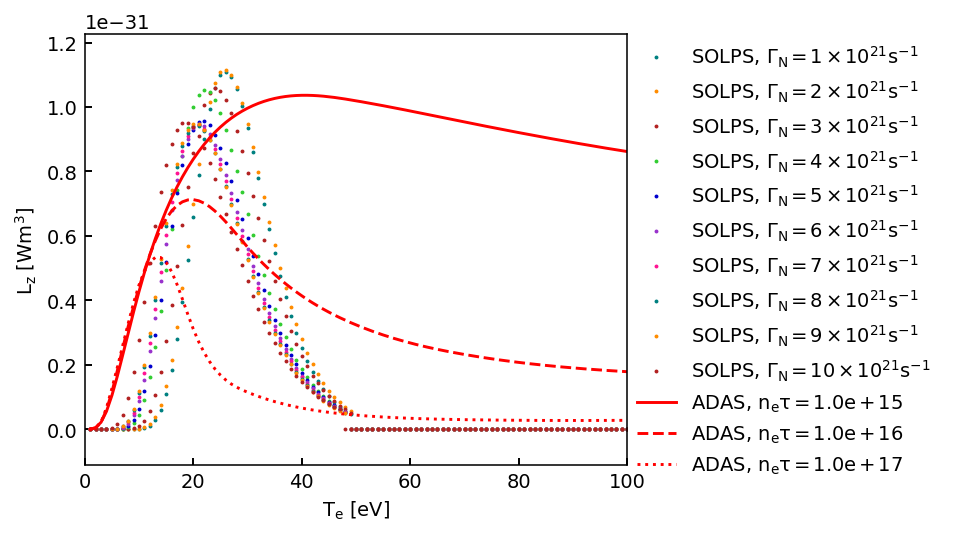

In [9]:
species = "N"
sepadd = 3
region = "inner_lower"

fig, ax = plt.subplots()

Tlo = 1
Thi = 500

T = np.linspace(Tlo, Thi, 500)

df_curves = []
for case in store_slc:
    slc = store_slc[case]
    fun = slc.extract_cooling_curve(species, region, sepadd = sepadd, order = 2, plot = False)

    Lz = [fun(temp) for temp in T]
    
    df_curve = pd.DataFrame()
    df_curve["T"] = T
    df_curve["Lz"] = Lz
    df_curves.append(df_curve)
    ax.plot(T, Lz, marker = "o", ms = 1, lw = 0, label = "SOLPS, "+seed_label(case))
    

allcurves = pd.concat(df_curves).sort_values("T")
allcurves = allcurves.groupby("T").mean().reset_index()
N_allcurvefit = sp.interpolate.interp1d(allcurves["T"], allcurves["Lz"], kind = "cubic")
N_allcurvefit = sp.interpolate.interp1d(allcurves["T"], allcurves["Lz"], kind = "cubic",
                                        fill_value = (N_allcurvefit(Tlo), N_allcurvefit(Thi)), bounds_error = False)
# ax.plot(T, [N_allcurvefit(temp) for temp in T], label = "SOLPS fit", c = "k", ls = "--", alpha = 1,  lw = 2)

linestyles = ["-", "--", ":"]

for i, netau in enumerate([1e15, 1e16, 1e17]):
    ax.plot(T, [curves["N"][netau](temp) for temp in T], label = rf"ADAS, $n_{{e}}\tau={netau:.1e}$", c = "r", ls = linestyles[i])
ax.legend(loc = "upper left", bbox_to_anchor=(1,1), frameon = False)
ax.set_xlim(0,100)
ax.set_xlabel("$T_e$ [eV]")
ax.set_ylabel("$L_{z}$ [$Wm^{3}$]")
ax.grid(which = "both", visible = False)
# ax.set_title("Cross-case Lz comparison to ADAS")

## Case comparison

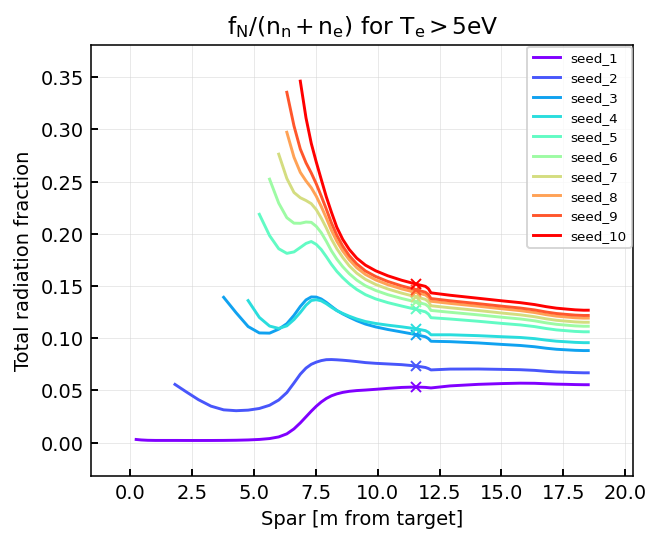

In [ ]:
num_cases = len(store_slc)
colors = [plt.get_cmap("rainbow")(i) for i in np.linspace(0, 1, num_cases)]

fig, ax = plt.subplots()
for i, case in enumerate(store_slc):
    slc = store_slc[case]
    df = slc.get_1d_poloidal_data(params = ["Ne", "Nn", "Te", "fN", "fNtot", "RN", "Btot"], sepadd = 4, region = "outer_lower", target_first = True)
    df["Lz"] = df["RN"] / (df["ne"]**2 * df["fN"])
    df = df[df["Te"]>5]
    
    dfx = df[df["Xpoint"]==1]
    
    ax.plot(df["Spar"], df["fN"], color = colors[i], label = case)
    ax.plot(dfx["Spar"], dfx["fN"], color = colors[i], marker = "x", ms = 5) 
    
ax.set_title("$f_N / (n_n+n_e)$ for $T_e>5eV$")
ax.set_xlabel("Spar [m from target]")
ax.set_ylabel("Total radiation fraction")
ax.legend(fontsize = "x-small")


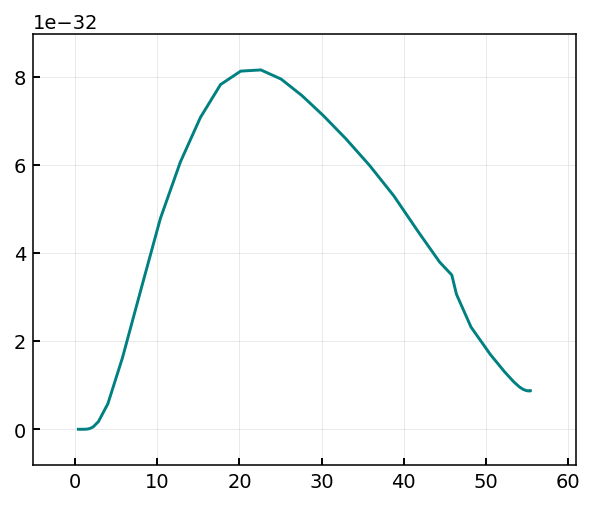

In [30]:
self = slc
species = "N"
sepadd = 3
region = "outer_lower"
df = self.get_1d_poloidal_data(["Te", f"R{species}", f"f{species}", "ne"], sepadd = sepadd, region = region)

x = df["Te"]
y = df["RN"] / (df["ne"]**2 * df["fN"])

fig, ax = plt.subplots()
ax.plot(x,y)

# Case analysis

## Power balance

In [83]:
fline_right.query("Xpoint == 1")

R         Z      Spol    fhex_total  fhey_total       Spar  \
15  0.618766 -1.352073  1.110545  70518.242265   75.768546  10.776556   

        apar  Xpoint  
15  0.003481       1

In [10]:
omkar_fig9 = {}

omkar_fig9["Pradial"] = pd.read_csv(r"C:\Users\mikek\OneDrive\Project\DLS\digitised_plots\myatra_2023_fig9a_ring5_Pradial.csv", header = None, names = ["Te", "value"])
omkar_fig9["Pdiv"] = pd.read_csv(r"C:\Users\mikek\OneDrive\Project\DLS\digitised_plots\myatra_2023_fig9a_ring5_Pdiv.csv", header = None, names = ["Te", "value"])
omkar_fig9["PH"] = pd.read_csv(r"C:\Users\mikek\OneDrive\Project\DLS\digitised_plots\myatra_2023_fig9a_ring5_PH.csv", header = None, names = ["Te", "value"])
omkar_fig9["Ploss"] = pd.read_csv(r"C:\Users\mikek\OneDrive\Project\DLS\digitised_plots\myatra_2023_fig9a_ring5_Ploss.csv", header = None, names = ["Te", "value"])
omkar_fig9["PCN"] = pd.read_csv(r"C:\Users\mikek\OneDrive\Project\DLS\digitised_plots\myatra_2023_fig9a_ring5_P_CN.csv", header = None, names = ["Te", "value"])

In [71]:
%matplotlib inline

(0.0, 12.0)

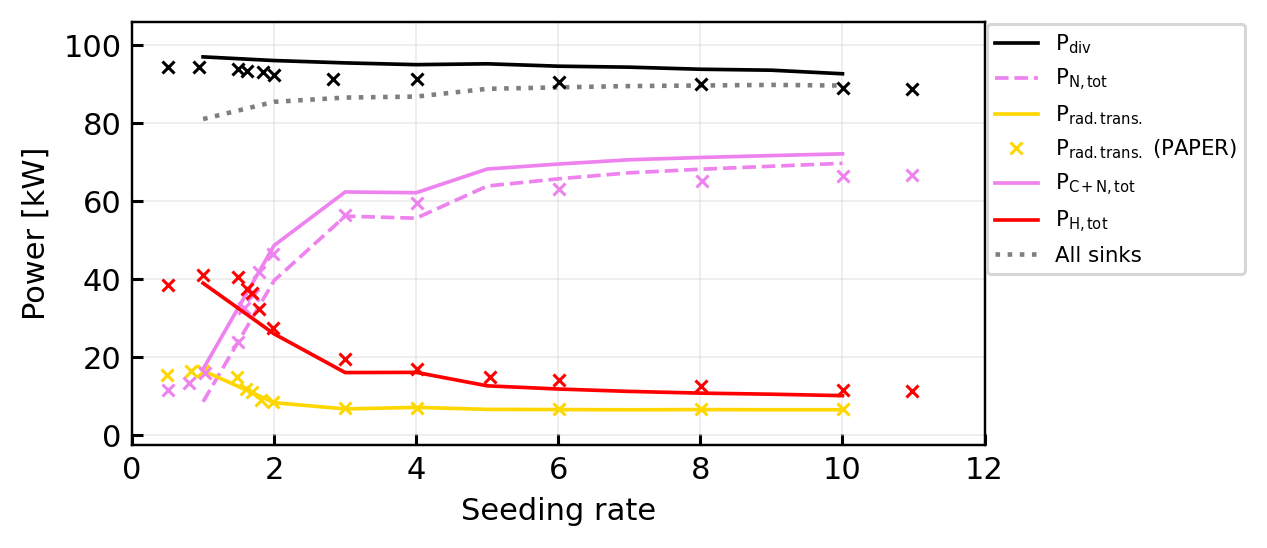

In [81]:
sepadd = 0
df = pd.DataFrame()
region = "outer_lower"
case = "100MW_innerar_midplanepuff"

for i, case in enumerate(store_slc):
    solps = store_slc[case]
    seed = i+1
    fluxlist = ["fhex_total", "fhey_total", "fhix_total", "fhiy_total", "fhey_32", "fhey_cond", "fhiy_32", "fhiy_cond"]
    fline = solps.get_1d_poloidal_data(["RN", "RC", "vol", "Rd+_exiz", "Rd+_mol"] + fluxlist, sepadd = 4, region = region, target_first = True)
    fline_right = solps.get_1d_poloidal_data(fluxlist, sepadd = 4+1, region = region, target_first = True)
    fline_x = fline.query("Xpoint == 1").squeeze()  # First cell after X-point
    fline_right_x = fline_right.query("Xpoint == 1").squeeze()
    fline_div = fline.query("region == 'divertor'")   # Cells below X-point
    fline_right_div = fline_right.iloc[:fline_right_x.name]
    
    
    ## Calculate divergence explicitly like Omkar
    net_divergence = lambda flux: (fline_right_div[flux] - fline_div[flux]).sum()
    df.loc[seed, "Q_perp_out_check"] = net_divergence("fhey_32") + net_divergence("fhey_cond") + net_divergence("fhiy_32") + net_divergence("fhiy_cond")
    
    ## Calculate with 5/3 factor on fh_32
    hflux_rad_net_e = (fline_right_div["fhey_total"] - fline_div["fhey_total"]).sum() 
    hflux_rad_net_i = (fline_right_div["fhiy_total"] - fline_div["fhiy_total"]).sum() 
    df.loc[seed, "Q_perp_out"] = abs(hflux_rad_net_e) + abs(hflux_rad_net_i)
    
    ## Other calculations
    df.loc[seed, "Q_N"] = (fline["RN"] * fline["vol"]).sum()
    df.loc[seed, "Q_NC"] = ((fline["RN"] + fline["RC"]) * fline["vol"]).sum()
    df.loc[seed, "Q_H"] = ((fline["Rd+_exiz"].abs() + fline["Rd+_mol"].abs()) * fline["vol"]).sum()
    df.loc[seed, "Q_xpoint"] = fline_x["fhex_total"] + fline_x["fhix_total"]

df /= 1e3
df["Q_allsinks"] = df["Q_NC"] + df["Q_H"] + df["Q_perp_out"]

fig, ax = plt.subplots(figsize = (5,2.5), dpi = 220)

markerstyle = dict(marker = "x", ms = 4, lw = 0)

## Pdiv
ax.plot(df.index, df["Q_xpoint"],          lw = 1.2, c = "k",  label = "$P_{div}$")
ax.plot(omkar_fig9["Pdiv"]["Te"], omkar_fig9["Pdiv"]["value"], c = "k", **markerstyle)

## PN
ax.plot(df.index, df["Q_N"],               lw = 1.2, c = "violet", ls = "--", label = "$P_{N,tot}$")

## Pradial
ax.plot(df.index, df["Q_perp_out_check"],        lw = 1.2, c = "gold", label = "$P_{rad. trans.}$")
# ax.plot(df.index, df["Q_perp_out_check"],  lw = 0, c = "gold", marker = "o")
ax.plot(omkar_fig9["Pradial"]["Te"], omkar_fig9["Pradial"]["value"], c = "gold", **markerstyle, label = "$P_{rad. trans.}$ (PAPER)")

## P_N+C
ax.plot(df.index, df["Q_NC"],              lw = 1.2, c = "violet", label = r"$P_{C+N,tot}$")
ax.plot(omkar_fig9["PCN"]["Te"], omkar_fig9["PCN"]["value"], c = "violet", **markerstyle)

## P_H
ax.plot(df.index, df["Q_H"],               lw = 1.2, c = "red", label = "$P_{H,tot}$")
ax.plot(omkar_fig9["PH"]["Te"], omkar_fig9["PH"]["value"], c = "red", **markerstyle)

## P_allsinks
ax.plot(df.index, df["Q_allsinks"], c = "k", ls = ":", alpha = 0.5, label = "All sinks")

ax.legend(loc = "upper left", bbox_to_anchor=(1,1), fontsize = "x-small")
ax.set_xlabel("Seeding rate")
ax.set_ylabel("Power [kW]")
ax.set_xlim(0,12)
# ax.set_ylim(0,100)


In [79]:
df.loc[1]

Q_perp_out_check    16.506977
Q_perp_out          25.218131
Q_N                  8.498715
Q_NC                16.869720
Q_H                 38.914937
Q_xpoint            96.942042
Q_allsinks          81.002788
Name: 1, dtype: float64

In [ ]:
store_slc["seed_1"].get_leg_energy_balance(sepadd = 4, region = "outer_lower")

{'Q_N': 1405.6765609826712,
 'Q_C': 3640.9930513148133,
 'Q_H': 4954.552806215233,
 'Q_xpoint': 36733.7489015011,
 'Q_perp_out_e': 71562.24371336671,
 'Q_perp_out_i': 65060.67390446129,
 'Q_perp_out': 136622.917617828}

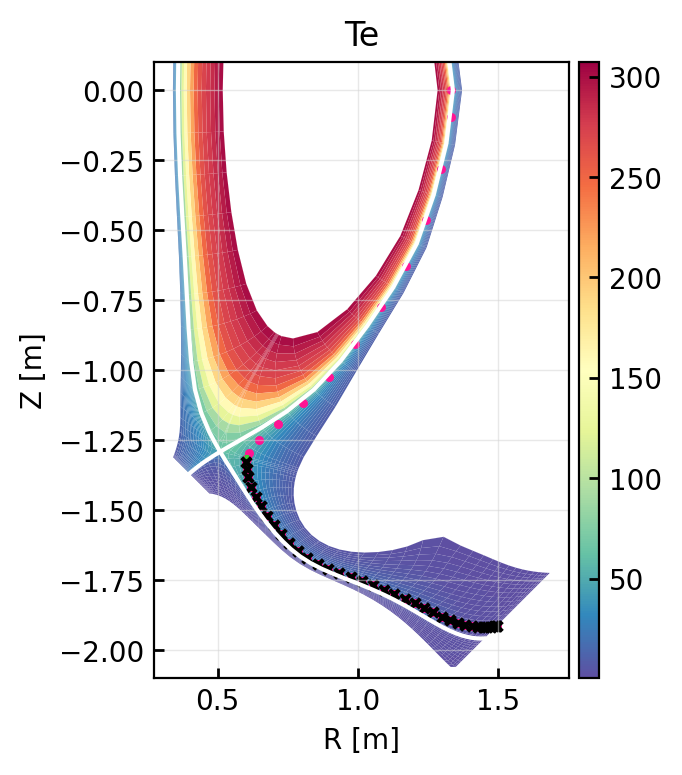

In [64]:
fig, ax = plt.subplots(dpi = 200)


slc.plot_2d("Te", ax = ax)
ax.set_ylim(-2.1, 0.1) ## LOWER
# ax.set_ylim(-0.1, 2.1) ## UPPER

region = "outer_lower"
fline = solps.get_1d_poloidal_data(["R", "Z"], sepadd = 4, region = region, target_first = True)
fline_x = fline.query("Xpoint == 'after'").squeeze()
fline_sol = fline.iloc[:fline_x.name]

ax.scatter(fline["R"], fline["Z"], s = 5, c = "deeppink")
ax.scatter(fline_x["R"], fline_x["Z"], s = 9, marker = "+", c = "limegreen")
ax.scatter(fline_sol["R"], fline_sol["Z"], s = 12, marker = "x", c = "k")

In [8]:
%matplotlib widget

In [17]:
slc.get_1d_poloidal_data(["fhey_52", "fhey_32"], region = "outer_lower", sepadd = 4, target_first = True)

R         Z      Spol  fhey_52      fhey_32       Spar      apar  \
49  1.496767 -1.913257  0.000000      0.0     0.000000   0.000000  0.007348   
48  1.493882 -1.913744  0.000058      0.0    -2.190819   0.000955  0.007233   
47  1.486660 -1.914840  0.005851      0.0    -5.643170   0.097290  0.007215   
46  1.476457 -1.916052  0.014668      0.0   -10.937585   0.246815  0.007172   
45  1.463346 -1.917029  0.026405      0.0   -17.468656   0.450748  0.007115   
44  1.447410 -1.917331  0.040971      0.0   -24.246547   0.710387  0.007036   
43  1.428767 -1.916449  0.058296      0.0   -30.105570   1.026035  0.006944   
42  1.407586 -1.913858  0.078323      0.0   -38.262654   1.395744  0.006840   
41  1.384084 -1.909095  0.101007      0.0   -53.571957   1.814362  0.006725   
40  1.358482 -1.901860  0.126320      0.0   -75.677182   2.273472  0.006599   
39  1.330960 -1.892057  0.154251      0.0   -78.228658   2.762228  0.006466   
38  1.301639 -1.879793  0.184780      0.0   -41.921556   3.268734  0.006332   
37  1.270593 -1.865433  0.217832      0.0    15.609605   3.780710  0.006179   
36  1.237888 -1.849572  0.253200      0.0    70.470460   4.285125  0.006012   
35  1.203625 -1.832911  0.290529      0.0   117.544118   4.769180  0.005845   
34  1.167931 -1.816135  0.329398      0.0   170.219591   5.221884  0.005671   
33  1.130973 -1.799754  0.369412      0.0   222.476537   5.635237  0.005484   
32  1.092948 -1.784034  0.410257      0.0   262.468496   6.005345  0.005283   
31  1.054075 -1.768989  0.451710      0.0   279.437792   6.332655  0.005071   
30  1.014575 -1.754439  0.493627      0.0   246.037412   6.621119  0.004862   
29  0.974700 -1.740024  0.535902      0.0   235.846081   6.876892  0.004669   
28  0.934779 -1.725188  0.578427      0.0   247.672022   7.107269  0.004462   
27  0.895260 -1.709166  0.621083      0.0   240.338369   7.320143  0.004256   
26  0.856761 -1.691029  0.663732      0.0   229.769240   7.523228  0.004063   
25  0.820030 -1.669904  0.706247      0.0   202.737311   7.723245  0.003888   
24  0.785757 -1.645305  0.748571      0.0   187.533078   7.925436  0.003737   
23  0.754297 -1.617391  0.790743      0.0   178.701225   8.133873  0.003594   
22  0.725607 -1.586851  0.832793      0.0   166.660831   8.353180  0.003471   
21  0.699503 -1.554483  0.874618      0.0   156.092619   8.590293  0.003367   
20  0.675898 -1.520903  0.916007      0.0   142.138576   8.854483  0.003266   
19  0.654801 -1.486538  0.956753      0.0   123.823731   9.156241  0.003172   
18  0.636297 -1.451750  0.996694      0.0   100.746720   9.507042  0.003102   
17  0.620780 -1.416992  1.035596      0.0    78.914520   9.920336  0.003044   
16  0.609286 -1.383198  1.072878      0.0    53.645084  10.409469  0.002986   
15  0.603283 -1.352680  1.107097      0.0    31.942495  10.970379  0.002933   
14  0.602642 -1.329686  1.135300      0.0    15.279363  11.531745  0.002907   
13  0.603977 -1.318130  1.153304      0.0     4.590866  11.931375  0.002935   
12  0.605092 -1.313337  1.158594      0.0     0.919958  12.052181  0.002936   
11  0.613697 -1.294718  1.163149      0.0     7.957517  12.156296  0.002941   
10  0.648152 -1.251003  1.199695      0.0    29.867074  12.930023  0.003299   
9   0.715481 -1.191276  1.275688      0.0    98.931902  14.066870  0.003657   
8   0.803541 -1.117767  1.380079      0.0   281.967846  15.022646  0.004005   
7   0.897885 -1.023766  1.505167      0.0   630.729637  15.764314  0.004370   
6   0.991440 -0.908212  1.646967      0.0  1180.110296  16.342189  0.004643   
5   1.084408 -0.775779  1.802829      0.0  1831.306379  16.809808  0.004844   
4   1.172848 -0.627679  1.970677      0.0  2424.867296  17.221311  0.005067   
3   1.244713 -0.462012  2.148237      0.0  2994.889816  17.609036  0.005236   
2   1.297410 -0.282587  2.332999      0.0  3480.895228  17.976669  0.005311   
1   1.331723 -0.095265  2.522618      0.0  3639.967865  18.330192  0.005420   
0   1.331723  0.000000  2.618590      0.0  3639.746859  18.50

KeyError: 'outer_lower_target_guard'

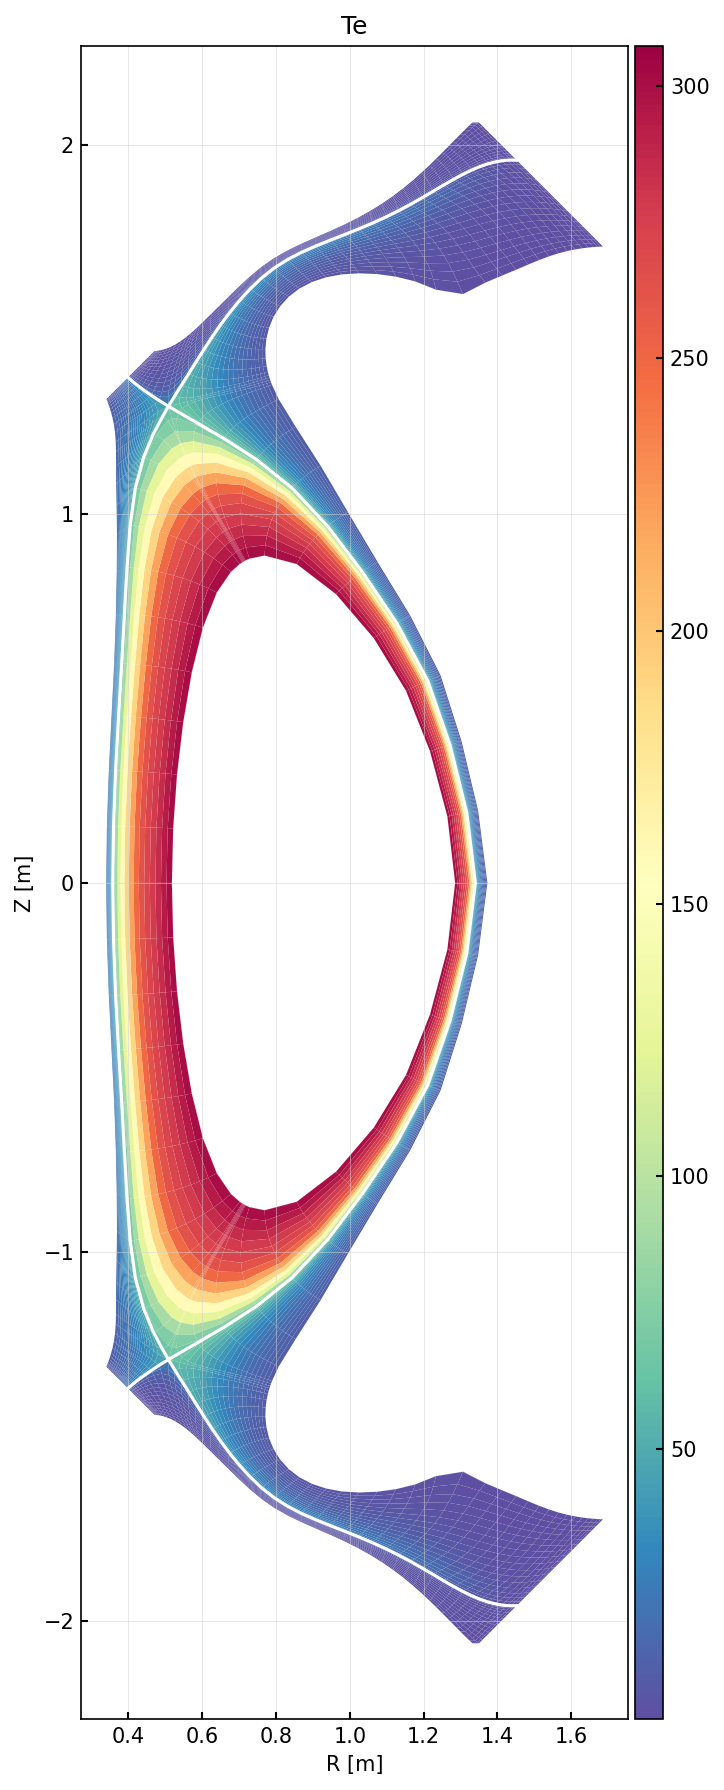

In [32]:
plt.close("all")
fig, ax = plt.subplots(dpi = 150, figsize = (5,15))

slc.plot_2d("Te", ax = ax)
p_idx = slc.poloidal_sel["outer_lower_target_guard"] - slc.poloidal_sel["outer_lower_xpoint"]

g = slc.g
ax.scatter(g["R"][p_idx, :], g["Z"][p_idx, :], c = "r", s = 1)

Text(0, 0.5, 'Power [kW]')

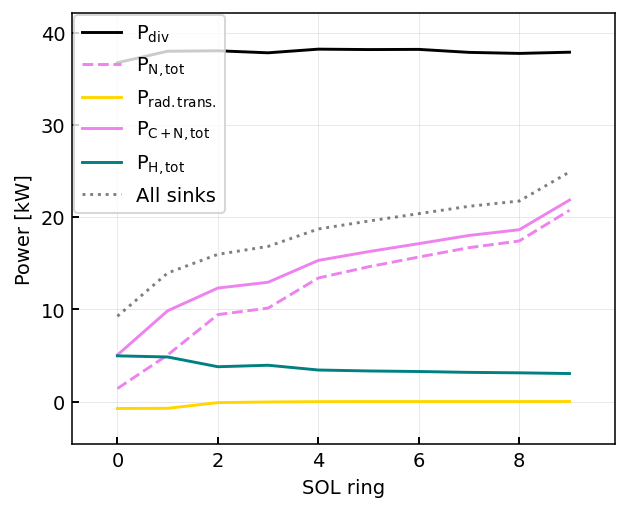

In [111]:
sepadd = 5
df = pd.DataFrame()
region = "outer_lower"
case = "100MW_innerar_midplanepuff"

for i, case in enumerate(store_slc):
    balance = store_slc[case].get_leg_energy_balance(sepadd = sepadd, region = region, impurities = ["N", "C"])
    
    df.loc[i, "Q_N"] = balance["Q_N"]
    df.loc[i, "Q_NC"] = balance["Q_N"] + balance["Q_C"]
    df.loc[i, "Q_H"] = balance["Q_H"]
    
    df.loc[i, "Q_xpoint"] = balance["Q_xpoint"]
    df.loc[i, "Q_perp_out"] = balance["Q_perp_out"]

df /= 1e3
df["Q_allsinks"] = df["Q_NC"] + df["Q_H"] + df["Q_perp_out"]

fig, ax = plt.subplots()
ax.plot(df.index, df["Q_xpoint"], c = "k",  label = "$P_{div}$")
ax.plot(df.index, df["Q_N"], c = "violet", ls = "--", label = "$P_{N,tot}$")
ax.plot(df.index, df["Q_perp_out"], c = "gold", label = "$P_{rad. trans.}$")
ax.plot(df.index, df["Q_NC"], c = "violet", label = r"$P_{C+N,tot}$")
ax.plot(df.index, df["Q_H"], label = "$P_{H,tot}$")

ax.plot(df.index, df["Q_allsinks"], c = "k", ls = ":", alpha = 0.5, label = "All sinks")

ax.legend()
ax.set_xlabel("SOL ring")
ax.set_ylabel("Power [kW]")


## Temperature

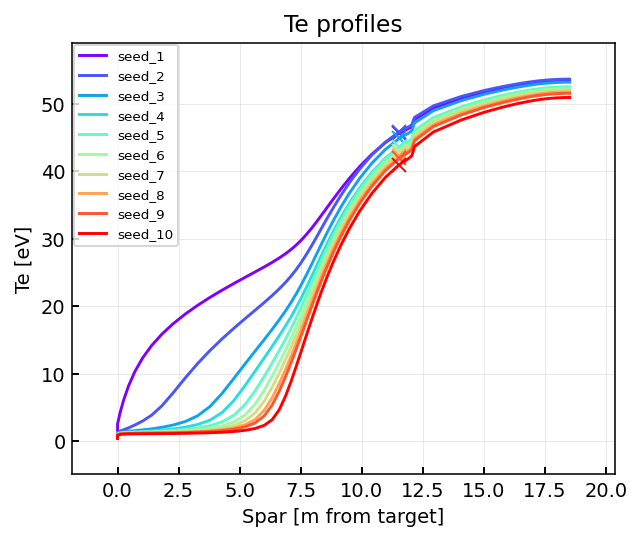

In [26]:
num_cases = len(store_slc)
colors = [plt.get_cmap("rainbow")(i) for i in np.linspace(0, 1, num_cases)]

fig, ax = plt.subplots()
for i, case in enumerate(store_slc):
    slc = store_slc[case]
    df = slc.get_1d_poloidal_data(params = ["Ne", "Te", "fN", "RN"], sepadd = 4, region = "outer_lower", target_first = True)
    dfx = df[df["Xpoint"]==1]
    ax.plot(df["Spar"], df["Te"], color = colors[i], label = case)
    ax.plot(dfx["Spar"], dfx["Te"], color = colors[i], marker = "x", ms = 7)
    
ax.set_title("Te profiles")
ax.set_xlabel("Spar [m from target]")
ax.set_ylabel("Te [eV]")
ax.legend(fontsize = "x-small")


## Density

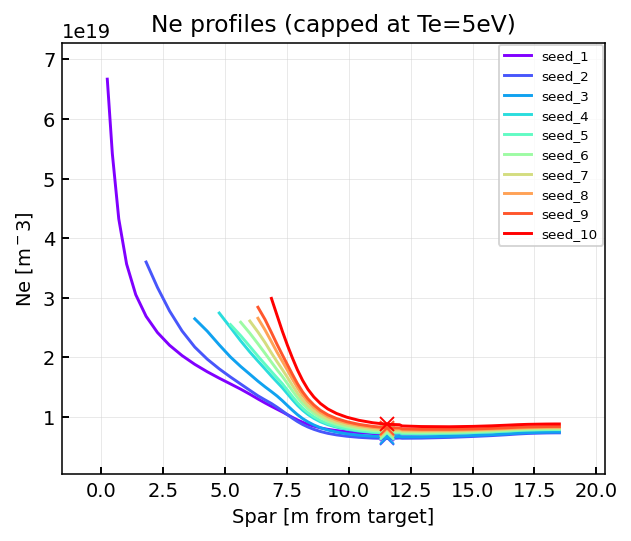

In [157]:
num_cases = len(store_slc)
colors = [plt.get_cmap("rainbow")(i) for i in np.linspace(0, 1, num_cases)]

fig, ax = plt.subplots()
for i, case in enumerate(store_slc):
    slc = store_slc[case]
    df = slc.get_1d_poloidal_data(params = ["Ne", "Te", "fN", "RN"], sepadd = 4, region = "outer_lower", target_first = True)
    df = df[df["Te"]>5]
    dfx = df[df["Xpoint"]==1]
    ax.plot(df["Spar"], df["Ne"], color = colors[i], label = case)
    ax.plot(dfx["Spar"], dfx["Ne"], color = colors[i], marker = "x", ms = 7)
    
ax.set_title("Ne profiles (capped at Te=5eV)")
ax.set_xlabel("Spar [m from target]")
ax.set_ylabel("Ne [$m^-3$]")
ax.legend(fontsize = "x-small")


## Radiation front

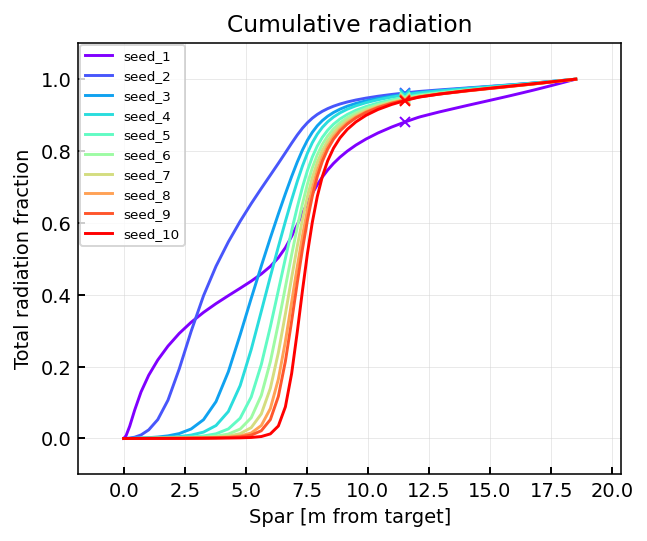

In [28]:
num_cases = len(store_slc)
colors = [plt.get_cmap("rainbow")(i) for i in np.linspace(0, 1, num_cases)]

fig, ax = plt.subplots()
for i, case in enumerate(store_slc):
    slc = store_slc[case]
    df = slc.get_1d_poloidal_data(params = ["Ne", "Te", "fN", "RN", "Btot"], sepadd = 4, region = "outer_lower", target_first = True)
    cumR = sp.integrate.cumulative_trapezoid(y = df["RN"] / df["Btot"], x = df["Spar"], initial = 0)
    df["cumR"] = cumR/cumR[-1]
    dfx = df[df["Xpoint"]==1]
    
    ax.plot(df["Spar"], df["cumR"], color = colors[i], label = case)
    ax.plot(dfx["Spar"], dfx["cumR"], color = colors[i], marker = "x", ms = 5) 
    
ax.set_title("Cumulative radiation")
ax.set_xlabel("Spar [m from target]")
ax.set_ylabel("Total radiation fraction")
ax.legend(fontsize = "x-small")


## Total parallel heat flux

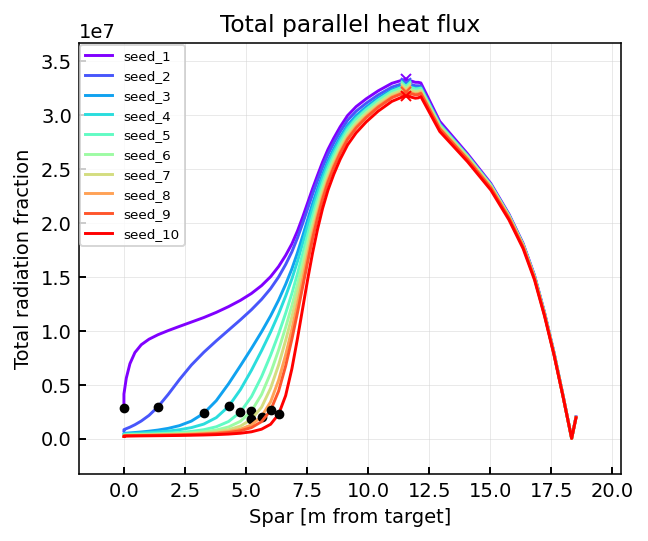

In [42]:
region = "outer_lower"

num_cases = len(store_slc)
colors = [plt.get_cmap("rainbow")(i) for i in np.linspace(0, 1, num_cases)]

fig, ax = plt.subplots()
for i, case in enumerate(store_slc):
    slc = store_slc[case]
    df = slc.get_1d_poloidal_data(params = ["fhx_total"], sepadd = 4, region = region, target_first = True)
    df["qpar"] = abs(df["fhx_total"]) / df["apar"]
    dfx = df[df["Xpoint"]==1]
    front_pos =  slc.extract_front_pos(sepadd = sepadd, region = region, method = "qpar", threshold = 0.03)
    front_idx = (df["Spar"] - front_pos).abs().idxmin()
    df_front = df.loc[front_idx]
    
    ax.plot(df["Spar"], df["qpar"], color = colors[i], label = case)
    ax.plot(dfx["Spar"], dfx["qpar"], color = colors[i], marker = "x", ms = 5) 
    ax.plot(df_front["Spar"], df_front["qpar"], color = "k", marker = "o", ms = 4) 
    
ax.set_title("Total parallel heat flux")
ax.set_xlabel("Spar [m from target]")
ax.set_ylabel("Total radiation fraction")
ax.legend(fontsize = "x-small")


## Enrichment

Empty DataFrame
Columns: []
Index: []

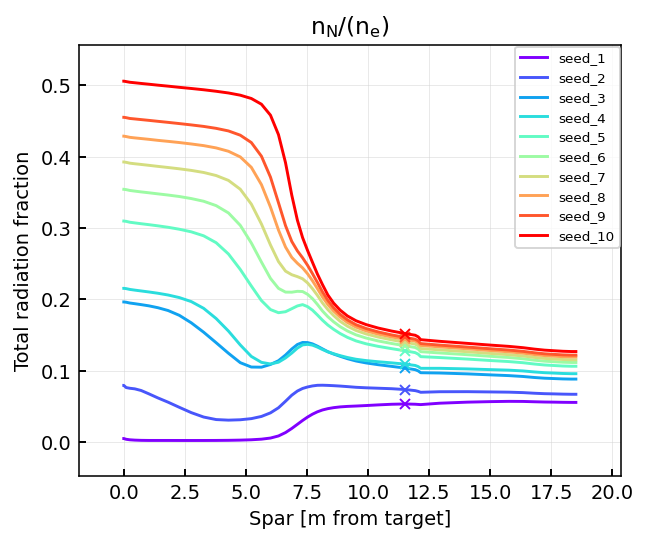

In [313]:
num_cases = len(store_slc)
colors = [plt.get_cmap("rainbow")(i) for i in np.linspace(0, 1, num_cases)]

average_cz = pd.DataFrame()

fig, ax = plt.subplots()
for i, case in enumerate(store_slc):
    slc = store_slc[case]
    df = slc.get_1d_poloidal_data(params = ["Ne", "Nn", "Te", "fN", "fNtot", "RN", "Btot", "vol"], sepadd = 4, region = "outer_lower", target_first = True)

    dfx = df[df["Xpoint"]==1]
    
    ax.plot(df["Spar"], df["fN"], color = colors[i], label = case)
    ax.plot(dfx["Spar"], dfx["fN"], color = colors[i], marker = "x", ms = 5) 
    
ax.set_title("$n_N / (n_e)$")
ax.set_xlabel("Spar [m from target]")
ax.set_ylabel("Total radiation fraction")
ax.legend(fontsize = "x-small")

display(average_cz)

## Enrichment at Te>5eV

Empty DataFrame
Columns: []
Index: []

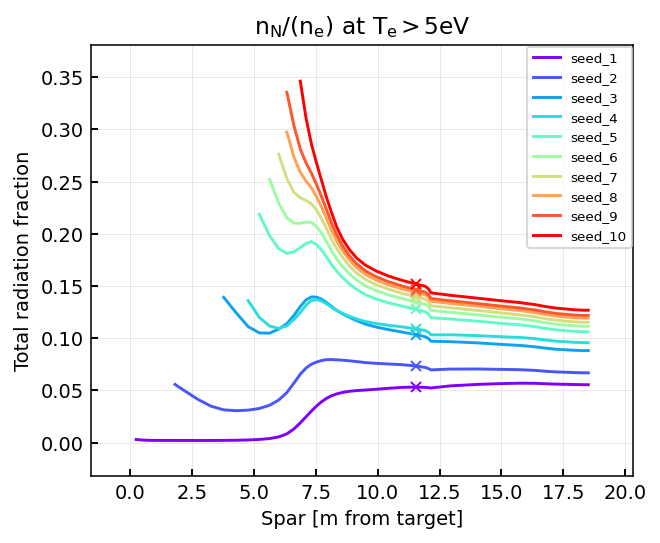

In [312]:
num_cases = len(store_slc)
colors = [plt.get_cmap("rainbow")(i) for i in np.linspace(0, 1, num_cases)]

average_cz = pd.DataFrame()

fig, ax = plt.subplots()
for i, case in enumerate(store_slc):
    slc = store_slc[case]
    df = slc.get_1d_poloidal_data(params = ["Ne", "Nn", "Te", "fN", "fNtot", "RN", "Btot", "vol"], sepadd = 4, region = "outer_lower", target_first = True)

    df = df[df["Te"]>5]
    dfx = df[df["Xpoint"]==1]
    
    ax.plot(df["Spar"], df["fN"], color = colors[i], label = case)
    ax.plot(dfx["Spar"], dfx["fN"], color = colors[i], marker = "x", ms = 5) 
    
ax.set_title("$n_N / (n_e)$ at $T_e>5eV$")
ax.set_xlabel("Spar [m from target]")
ax.set_ylabel("Total radiation fraction")
ax.legend(fontsize = "x-small")

display(average_cz)

Empty DataFrame
Columns: []
Index: []

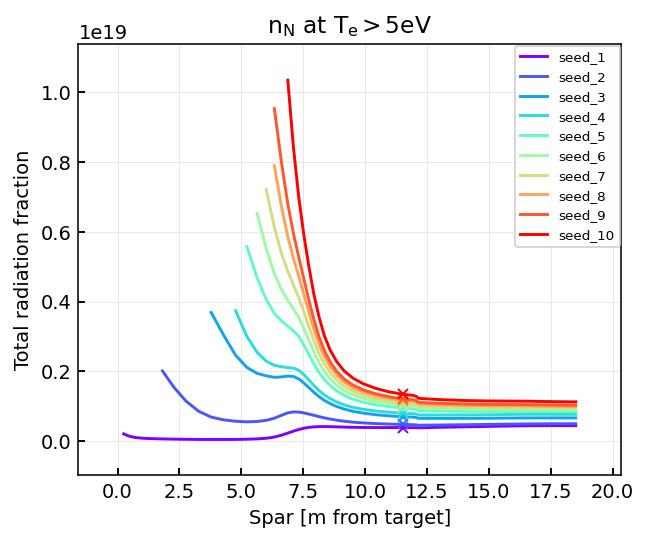

In [314]:
num_cases = len(store_slc)
colors = [plt.get_cmap("rainbow")(i) for i in np.linspace(0, 1, num_cases)]

average_cz = pd.DataFrame()

fig, ax = plt.subplots()
for i, case in enumerate(store_slc):
    slc = store_slc[case]
    df = slc.get_1d_poloidal_data(params = ["Ne", "Nn", "Te", "fN", "fNtot", "RN", "Btot", "vol"], sepadd = 4, region = "outer_lower", target_first = True)

    df = df[df["Te"]>5]
    dfx = df[df["Xpoint"]==1]
    
    ax.plot(df["Spar"], df["fN"]*df["Ne"], color = colors[i], label = case)
    ax.plot(dfx["Spar"], dfx["fN"]*dfx["Ne"], color = colors[i], marker = "x", ms = 5) 
    
ax.set_title("$n_N$ at $T_e>5eV$")
ax.set_xlabel("Spar [m from target]")
ax.set_ylabel("Total radiation fraction")
ax.legend(fontsize = "x-small")

display(average_cz)

## At what temp does radiation occur?

Empty DataFrame
Columns: []
Index: []

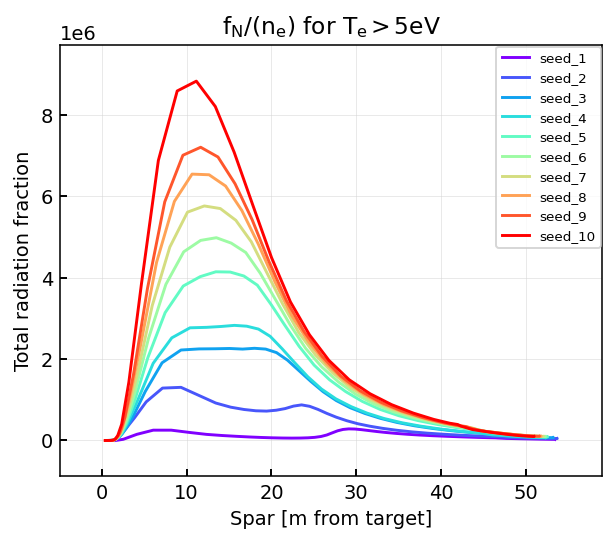

In [260]:
num_cases = len(store_slc)
colors = [plt.get_cmap("rainbow")(i) for i in np.linspace(0, 1, num_cases)]

average_cz = pd.DataFrame()

fig, ax = plt.subplots()
for i, case in enumerate(store_slc):
    slc = store_slc[case]
    df = slc.get_1d_poloidal_data(params = ["Ne", "Nn", "Te", "fN", "fNtot", "RN", "Btot", "vol"], sepadd = 4, region = "outer_lower", target_first = True)

    dfx = df[df["Xpoint"]==1]
    
    ax.plot(df["Te"], df["RN"], color = colors[i], label = case)
    # ax.plot(dfx["Spar"], dfx["fN"], color = colors[i], marker = "x", ms = 5) 
    
ax.set_title("$f_N / (n_e)$ for $T_e>5eV$")
ax.set_xlabel("Spar [m from target]")
ax.set_ylabel("Total radiation fraction")
ax.legend(fontsize = "x-small")

display(average_cz)

In [130]:
slc.bal["b2stel_she_bal"].shape

(148, 34, 17)

## Fraction of N radiation 

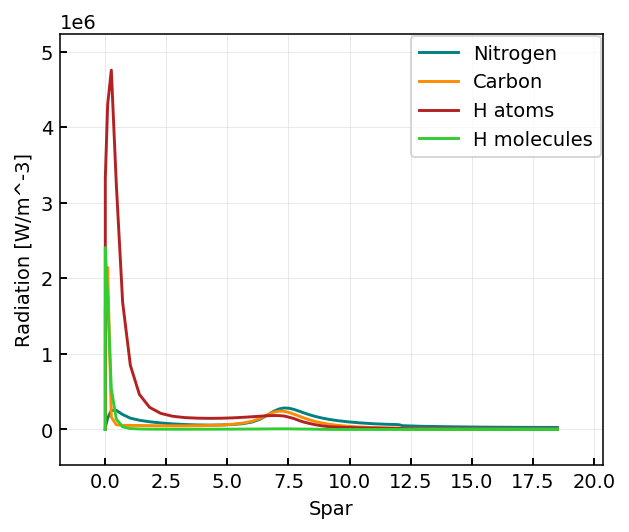

In [149]:
slc = store_slc["seed_1"]

df = slc.get_1d_poloidal_data(
        ["Te", "Ne", "Nn", "fN", "RN", "fC", "RC", "Btot", "fhx_total", "vol", "Rd+_atm", "Rd+_mol"], 
        sepadd = sepadd, region = region, target_first = True)

fig, ax = plt.subplots()

ax.plot(df["Spar"], df["RN"], label = "Nitrogen")
ax.plot(df["Spar"], df["RC"], label = "Carbon")
ax.plot(df["Spar"], abs(df["Rd+_atm"]), label = "H atoms")
ax.plot(df["Spar"], abs(df["Rd+_mol"]), label = "H molecules")
# ax.set_yscale("log")
ax.set_xlabel("Spar")
ax.set_ylabel("Radiation [W/m^-3]")
ax.legend()

## Conductivity

seed_1 kappa0: 1112.69
seed_2 kappa0: 935.68
seed_3 kappa0: 816.98
seed_4 kappa0: 804.84
seed_5 kappa0: 765.53
seed_6 kappa0: 752.14
seed_7 kappa0: 739.11
seed_8 kappa0: 729.39
seed_9 kappa0: 737.04
seed_10 kappa0: 744.51


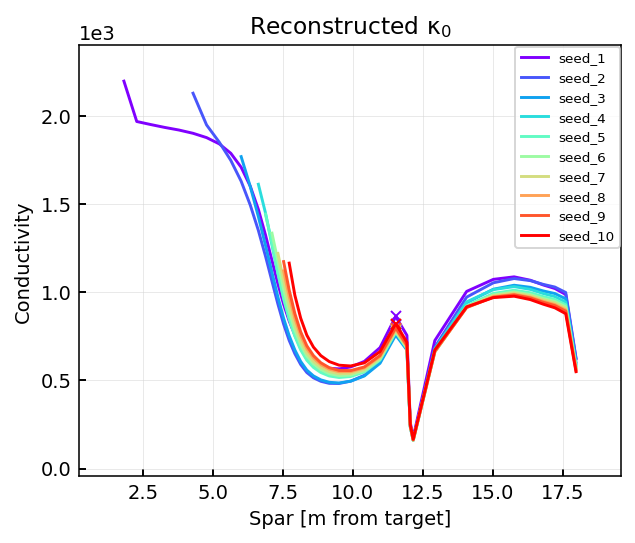

In [272]:
num_cases = len(store_slc)
colors = [plt.get_cmap("rainbow")(i) for i in np.linspace(0, 1, num_cases)]

fig, ax = plt.subplots()
for i, case in enumerate(store_slc):
    slc = store_slc[case]
    df = slc.get_1d_poloidal_data(params = ["Ne", "Nn", "Te", "fN", "fNtot", "RN", "Btot", "fhex_cond"], sepadd = 4, region = "outer_lower", target_first = True)
    df = df[df["Te"]>15]
    df = df.iloc[:-2]
    dfx = df[df["Xpoint"]==1].squeeze()
    
    
    qpar = df["fhex_cond"] / df["apar"]
    gradT = np.gradient(df["Te"], df["Spar"])
    df["kappa0"] = qpar / (df["Te"]**(5/2) * gradT) 

    dfx = df[df["Xpoint"]==1]
    ax.plot(df["Spar"], df["kappa0"], color = colors[i], label = case)
    ax.plot(dfx["Spar"], dfx["kappa0"], color = colors[i], marker = "x", ms = 5) 
    print(f"{case} kappa0: {df['kappa0'].mean():.2f}")
    
ax.set_title("Reconstructed $\kappa_0$")
ax.set_xlabel("Spar [m from target]")
ax.set_ylabel("Conductivity")
ax.legend(fontsize = "x-small")


# 2D plots

Text(0, 0.5, 'Z [m]')

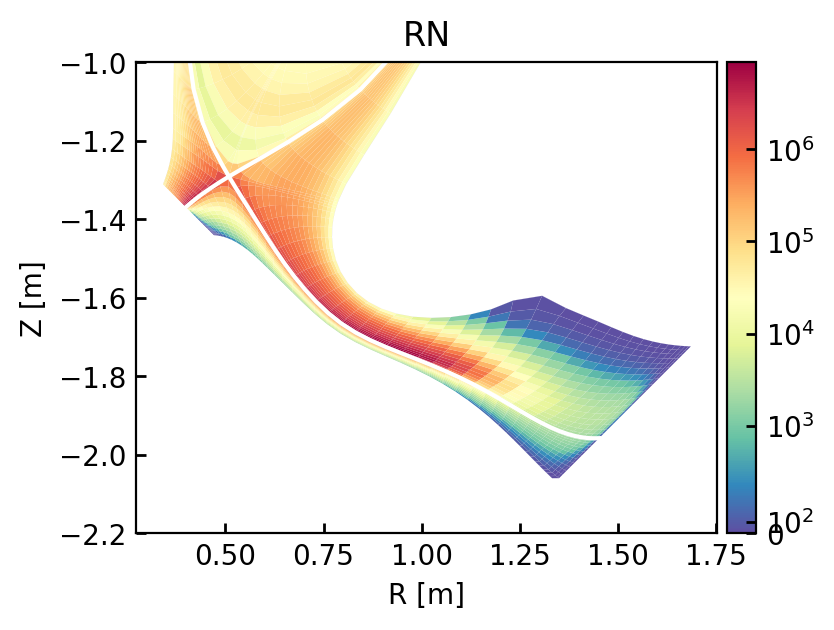

In [58]:
slc = store_slc["seed_9"]

fig, ax = plt.subplots(dpi = 200, figsize = (4,6), sharey = True)
slc.plot_2d(param = "RN",  ax = ax, 
            linewidth = 0, antialias = True, grid_only = False, vmax = None, vmin = None, logscale = True, separatrix = True,
            custom_cmap = "Spectral_r", cbar = True, axis_labels = False, alpha = 1)

ax.grid(False)

# V10
ax.set_ylim(-2.2, -1.0)

ax.set_xlabel("R [m]")
ax.set_ylabel("Z [m]")

# Run DLS

## Outer

In [55]:
store_slc.keys()
comps_outer = {}
outputs_outer = {}

In [54]:
def run_DLS(constants_input, slc, cvar, region, sepadd):

    # set switches
    radios_default = {
        "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
    }
    
    df = slc.get_1d_poloidal_data(params = ["fhx_total", "Ne"], sepadd = sepadd, region = region, target_first = True)
    qpar_max = (df["fhx_total"]/df["apar"]).max()
    nu = df["Ne"].iloc[-1]

    # set general run parameters
    constants_default = {
        "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
        "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
        "qpllu0": qpar_max,
        "nu": nu,  # Upstream density (if constant)
        "nu0": nu,  # Upstream density (if constant)
        "cz0": 0.05,  # Impurity fraction (if constant)
        # "Lfunc": LfuncKallenbach("N"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
        "Lfunc" : curves["N"][1e16],
        "kappa0" : slc.extract_kappa0(sepadd = sepadd, region = region)
    }
    print(nu)
    constants = {**constants_default, **constants_input}
    d = eqb_alt[case][region][sepadd]

    try: 
            out = run_dls(
                constants = constants, 
                radios = radios_default, 
                d = d,
                SparRange = [slc.extract_front_pos(sepadd = sepadd, region = region, impurity = "N", method = "qpar_tot", threshold = 0.05)],
                control_variable = cvar,
                verbosity = 0,
                Ctol = 1e-3,
                Ttol = 1e-3,
                dynamicGrid = True,
                dynamicGridRefinementRatio = 5,
                dynamicGridResolution = 5000,
                dynamicGridRefinementWidth = 2,
                dynamicGridDiagnosticPlot = False)
        
    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)

    return out, compare_SOLPS_DLS(slc, out, cvar, impurity = "N", region = region, sepadd = sepadd)

### ADAS curve

In [58]:
study = "adas_curve"
cvar = "impurity_frac"
comps_outer[study] = {}
outputs_outer[study] = {}

for case in ['seed_2', 'seed_3', 'seed_4', 'seed_5', 'seed_6', 'seed_7', 'seed_8', 'seed_9', 'seed_10']:
# for case in ["seed_2"]:

    input = {
        "Lfunc" : curves["N"][1e16],
        "kappa0" : slc.extract_kappa0(sepadd = sepadd, region = region)
    }
    
    outputs_outer[study][case], comps_outer[study][case] = run_DLS(input, store_slc[case],  cvar, "outer_lower", 4)  


7.349314747585587e+18
Solving...0.71...Complete in 1.7 seconds
7.47920383136815e+18
Solving...2.76...Complete in 0.9 seconds
7.945203100456895e+18
Solving...3.27...Complete in 1.4 seconds
7.890573565490004e+18
Solving...4.29...Complete in 0.7 seconds
8.011308061759071e+18
Solving...4.77...Complete in 1.0 seconds
8.155866553210362e+18
Solving...4.77...Complete in 1.0 seconds
8.29420242270149e+18
Solving...5.22...Complete in 1.5 seconds
8.419527733172039e+18
Solving...5.64...Complete in 1.3 seconds
8.840356150243571e+18
Solving...6.01...Complete in 1.3 seconds


### Fit curve

In [59]:
study = "fit_curve"
cvar = "impurity_frac"
comps_outer[study] = {}
outputs_outer[study] = {}

for case in ['seed_2', 'seed_3', 'seed_4', 'seed_5', 'seed_6', 'seed_7', 'seed_8', 'seed_9', 'seed_10']:

    input = {
        "Lfunc" : slc.extract_cooling_curve("N", region, sepadd = sepadd, plot = False),
        "kappa0" : slc.extract_kappa0(sepadd = sepadd, region = region)
    }
    
    outputs_outer[study][case], comps_outer[study][case] = run_DLS(input, store_slc[case],  cvar, "outer_lower", 4)  

7.349314747585587e+18
Solving...0.71...Complete in 0.6 seconds
7.47920383136815e+18
Solving...2.76...Complete in 1.6 seconds
7.945203100456895e+18
Solving...3.27...Complete in 0.5 seconds
7.890573565490004e+18
Solving...4.29...Complete in 1.1 seconds
8.011308061759071e+18
Solving...4.77...Complete in 1.5 seconds
8.155866553210362e+18
Solving...4.77...Complete in 1.5 seconds
8.29420242270149e+18
Solving...5.22...Complete in 1.7 seconds
8.419527733172039e+18
Solving...5.64...Complete in 1.5 seconds
8.840356150243571e+18
Solving...6.01...Complete in 1.5 seconds


### Other losses

In [60]:
study = "other_losses"
cvar = "impurity_frac"
comps_outer[study] = {}
outputs_outer[study] = {}

for case in ['seed_2', 'seed_3', 'seed_4', 'seed_5', 'seed_6', 'seed_7', 'seed_8', 'seed_9', 'seed_10']:

    input = {
        "Lfunc" : slc.extract_cooling_curve("N", region, sepadd = sepadd, other_losses = True, plot = False),
        "kappa0" : slc.extract_kappa0(sepadd = sepadd, region = region)
    }
    
    outputs_outer[study][case], comps_outer[study][case] = run_DLS(input, store_slc[case],  cvar, "outer_lower", 4)  

7.349314747585587e+18
Solving...0.71...Complete in 1.5 seconds
7.47920383136815e+18
Solving...2.76...Complete in 1.5 seconds
7.945203100456895e+18
Solving...3.27...Complete in 1.4 seconds
7.890573565490004e+18
Solving...4.29...Complete in 1.1 seconds
8.011308061759071e+18
Solving...4.77...Complete in 1.6 seconds
8.155866553210362e+18
Solving...4.77...Complete in 1.6 seconds
8.29420242270149e+18
Solving...5.22...Complete in 1.5 seconds
8.419527733172039e+18
Solving...5.64...Complete in 1.4 seconds
8.840356150243571e+18
Solving...6.01...Complete in 0.9 seconds


### Cz effect

In [61]:
study = "include_cz"
cvar = "impurity_frac"
comps_outer[study] = {}
outputs_outer[study] = {}

for case in ['seed_2', 'seed_3', 'seed_4', 'seed_5', 'seed_6', 'seed_7', 'seed_8', 'seed_9', 'seed_10']:

    input = {
        "Lfunc" : slc.extract_cooling_curve("N", region, sepadd = sepadd, plot = False, other_losses = True, cz_effect = True, ne_effect = False),
        "kappa0" : slc.extract_kappa0(sepadd = sepadd, region = region)
    }
    
    outputs_outer[study][case], comps_outer[study][case] = run_DLS(input, store_slc[case],  cvar, "outer_lower", 4)  

7.349314747585587e+18
Solving...0.71...Complete in 1.1 seconds
7.47920383136815e+18
Solving...2.76...Complete in 1.1 seconds
7.945203100456895e+18
Solving...3.27...Complete in 1.8 seconds
7.890573565490004e+18
Solving...4.29...Complete in 1.5 seconds
8.011308061759071e+18
Solving...4.77...Complete in 1.2 seconds
8.155866553210362e+18
Solving...4.77...Complete in 1.2 seconds
8.29420242270149e+18
Solving...5.22...Complete in 0.6 seconds
8.419527733172039e+18
Solving...5.64...Complete in 1.2 seconds
8.840356150243571e+18
Solving...6.01...Complete in 1.1 seconds


### Ne effect

In [62]:
study = "include_cz_ne"
comps_outer[study] = {}
outputs_outer[study] = {}

for case in ['seed_2', 'seed_3', 'seed_4', 'seed_5', 'seed_6', 'seed_7', 'seed_8', 'seed_9', 'seed_10']:

    input = {
        "Lfunc" : slc.extract_cooling_curve("N", region, sepadd = sepadd, plot = False, other_losses = True, cz_effect = True, ne_effect = True),
        "kappa0" : slc.extract_kappa0(sepadd = sepadd, region = region)
    }
    
    outputs_outer[study][case], comps_outer[study][case] = run_DLS(input, store_slc[case],  cvar, "outer_lower", 4)  

7.349314747585587e+18
Solving...0.71...Complete in 1.5 seconds
7.47920383136815e+18
Solving...2.76...Complete in 1.4 seconds
7.945203100456895e+18
Solving...3.27...Complete in 1.5 seconds
7.890573565490004e+18
Solving...4.29...Complete in 1.4 seconds
8.011308061759071e+18
Solving...4.77...Complete in 1.1 seconds
8.155866553210362e+18
Solving...4.77...Complete in 1.3 seconds
8.29420242270149e+18
Solving...5.22...Complete in 0.5 seconds
8.419527733172039e+18
Solving...5.64...Complete in 1.3 seconds
8.840356150243571e+18
Solving...6.01...Complete in 0.5 seconds


# Multi case comparison SOLPS vs. DLS

## Format settings

In [41]:

DLSstyles = dict(
    adas_curve =    dict(lw = 0, marker = "o", ms = 3, markerfacecolor = "None"),
    fit_curve =     dict(lw = 0, marker = "x", ms = 4, markeredgewidth = 1, markerfacecolor = "None"),   
    other_losses =     dict(lw = 0, marker = "p", ms = 4, markeredgewidth = 1, markerfacecolor = "None"),   
    include_cz =    dict(lw = 0, marker = "s", ms = 3, markeredgewidth = 1, markerfacecolor = "None"),   
    include_cz_ne = dict(lw = 0, marker = "1", ms = 6, markeredgewidth = 1, markerfacecolor = "None"),   
)

SOLPSstyle = dict(lw = 2, ms = 0, c = "darkslategrey")

Xpointstyle = dict(ls = ":", lw = 1)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


study_labels = dict(
    adas_curve = "ADAS cooling curve",
    fit_curve = "Fitted cooling curve",
    other_losses = "Total rad. losses",
    include_cz = "Fix $f_{N}$",
    include_cz_ne = "Fix $f_{N}n_{e}^{2}$"
)

###### SELECT STUDIES/CASES
study_selection = [
    "adas_curve", 
    "fit_curve", 
    # "other_losses", 
    # "include_cz",
    # "include_cz_ne"
    ]

case_selection = ["seed_2", "seed_4",  "seed_10"]

figure_labels = ["a)", "b)", "c)"]

###### LEGEND
handles = []
## DLS legend
for study_no, study in enumerate(study_selection):
    handles.append(plt.Line2D([0], [0], **{**DLSstyles[study], **dict(ms = 7, markeredgewidth = 1.5)}, c = colors[study_no], label = study_labels[study]))
    
## SOLPS and X-point legend
handles.append(plt.Line2D([0], [0], **SOLPSstyle, label = "SOLPS-ITER"))    
handles.append(plt.Line2D([0], [0], **Xpointstyle, color = "deeppink", label = "X-point"))    

## Case names
# for i, case in enumerate(selection):
    # handles.append(plt.Line2D([0], [0], **SOLPSstyle, label = seed_label(case))) 


### Formatting macros
make_legend = lambda fig: fig.legend(handles = handles, ncols = 6, loc = "lower center", bbox_to_anchor = (0.5,0.97), frameon = False)

def make_grid(ax):
    ax.grid(which = "major", visible = True, c = "k", alpha = 0.15)
    ax.grid(which = "minor", visible = True, c = "k", alpha = 0.075)
    
make_title = lambda ax: ax.set_title(figure_labels[i], loc = "right", y = 0.02, x = 0.97, fontsize = 20)

def make_xpoint(spc, ax):
    ylim = ax.get_ylim()
    ax.vlines(spc[spc["Xpoint"]==1]["Spar"].values[0], *ylim, **Xpointstyle, color = "deeppink", label = "X-point")
    ax.set_ylim(ylim)

## Cooling curves

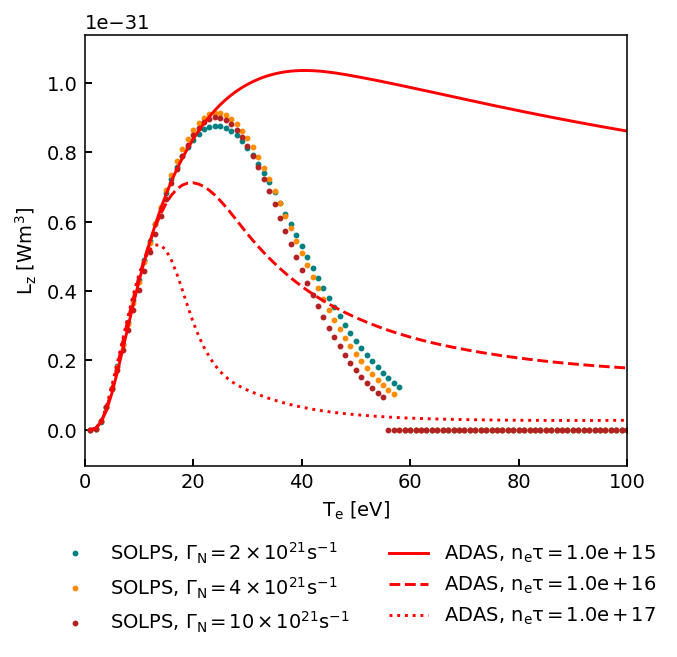

In [42]:
species = "N"
sepadd = 3
region = "outer_lower"

fig, ax = plt.subplots()

Tlo = 1
Thi = 500

T = np.linspace(Tlo, Thi, 500)

df_curves = []
for case in case_selection:
    slc = store_slc[case]
    fun = slc.extract_cooling_curve(species, region, sepadd = sepadd, order = 5, plot = False)

    Lz = [fun(temp) for temp in T]
    
    df_curve = pd.DataFrame()
    df_curve["T"] = T
    df_curve["Lz"] = Lz
    df_curves.append(df_curve)
    ax.plot(T, Lz, marker = "o", ms = 2, lw = 0, label = "SOLPS, "+seed_label(case))
    
linestyles = ["-", "--", ":"]

for i, netau in enumerate([1e15, 1e16, 1e17]):
    ax.plot(T, [curves["N"][netau](temp) for temp in T], label = rf"ADAS, $n_{{e}}\tau={netau:.1e}$", c = "r", ls = linestyles[i])
ax.legend(loc = "upper center", ncols = 2, bbox_to_anchor=(0.5, -0.15),fontsize = "medium",  frameon = False)
ax.set_xlim(0,100)
ax.set_xlabel("$T_e$ [eV]")
ax.set_ylabel("$L_{z}$ [$Wm^{3}$]")
ax.grid(which = "both", visible = False)
# ax.set_title("Cross-case Lz comparison to ADAS")

## Front width

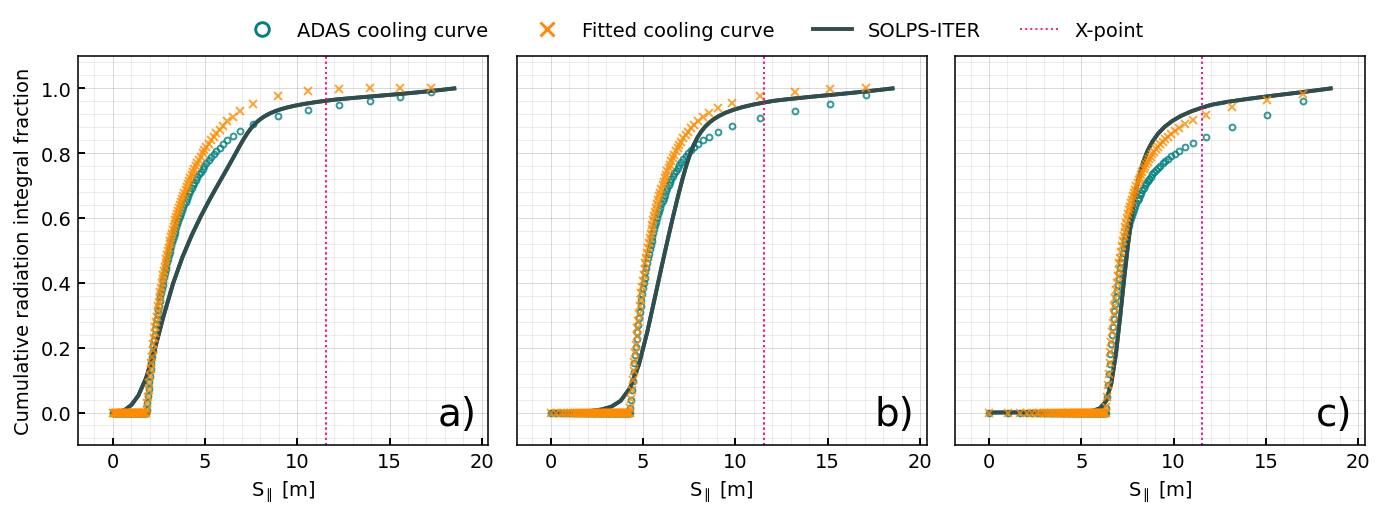

In [53]:
fig, axes = plt.subplots(1, 3, figsize = (10,3.5), sharey = True)

for study_no, study in enumerate(study_selection):
    for i, case in enumerate(case_selection):
        comp = comps_outer[study][case]
        dls = comp.dls
        spc = comp.solps  
        
        ax = axes[i]
        ax.plot(spc["Spar"], spc["Prad_cum_norm"], label = study, **SOLPSstyle)  # SOLPS
        ax.plot(dls["Spar"][::4], dls["Prad_cum_norm"][::4], **DLSstyles[study], c = colors[study_no], alpha = 0.8)   # DLS
        ax.set_xlabel("$S_{\parallel}$ [m]")

        if i > 0:
            ax.tick_params(axis = "y", which = "both", left = False, labelleft = False)
            
        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        make_grid(ax)
        make_title(ax)
        make_xpoint(spc, ax)
        
axes[0].set_ylabel("Cumulative radiation integral fraction")
fig.tight_layout()
make_legend(fig)
plt.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\MASTU_frontwidth.pdf", format = "pdf", bbox_inches = "tight")

## Impurity radiation

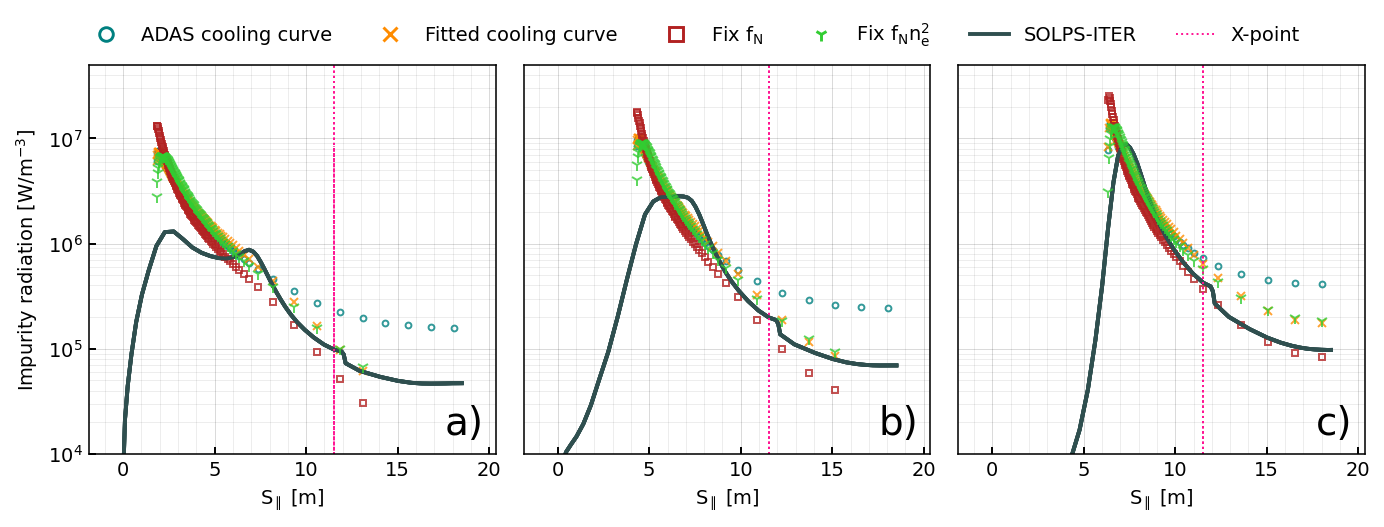

In [140]:
fig, axes = plt.subplots(1, 3, figsize = (10,3.5), sharey = True)

for study_no, study in enumerate(study_selection):
    for i, case in enumerate(case_selection):
        comp = comps_outer[study][case]
        dls = comp.dls
        spc = comp.solps  
        
        ax = axes[i]
        ax.plot(spc["Spar"], spc["RN"], label = study, **SOLPSstyle)  # SOLPS
        ax.plot(dls["Spar"][::3], dls["Qrad"][::3], **DLSstyles[study], c = colors[study_no], alpha = 0.8)   # DLS
        ax.set_xlabel("$S_{\parallel}$ [m]")
        
        if i > 0:
            ax.tick_params(axis = "y", which = "both", left = False, labelleft = False)
            
        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        make_grid(ax)
        make_title(ax)
        make_xpoint(spc, ax)
        ax.set_yscale("log")
        ax.set_ylim(1e4, 5e7)
        
axes[0].set_ylabel("Impurity radiation [$W/m^{-3}$]")
fig.tight_layout()
make_legend(fig)
# plt.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\MASTU_qrad.pdf", format = "pdf", bbox_inches = "tight")

## Temperature

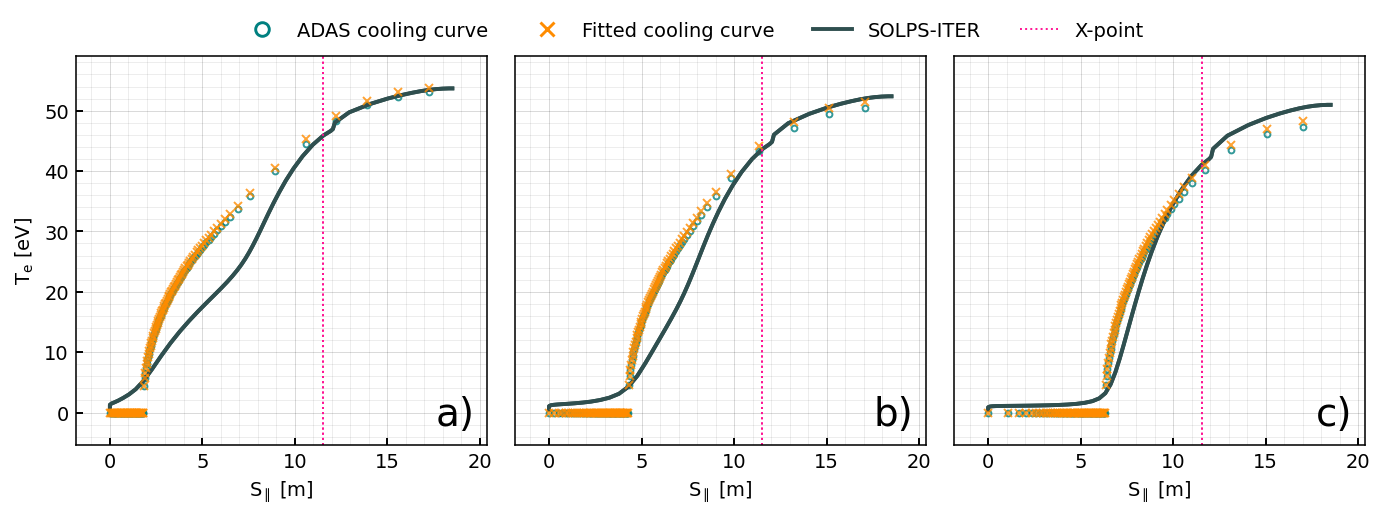

In [54]:
fig, axes = plt.subplots(1, 3, figsize = (10,3.5), sharey = True)

for study_no, study in enumerate(study_selection):
    for i, case in enumerate(case_selection):
        comp = comps_outer[study][case]
        dls = comp.dls
        spc = comp.solps  
        
        ax = axes[i]
        ax.plot(spc["Spar"], spc["Te"], label = study, **SOLPSstyle)  # SOLPS
        ax.plot(dls["Spar"][::4], dls["Te"][::4], **DLSstyles[study], c = colors[study_no], alpha = 0.8)   # DLS
        ax.set_xlabel("$S_{\parallel}$ [m]")

        if i > 0:
            ax.tick_params(axis = "y", which = "both", left = False, labelleft = False)
            
        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        make_xpoint(spc, ax)
        make_grid(ax)
        make_title(ax)
        
axes[0].set_ylabel("$T_e$ [eV]")
fig.tight_layout()
make_legend(fig)
plt.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\MASTU_temp.pdf", format = "pdf", bbox_inches = "tight")

## Density

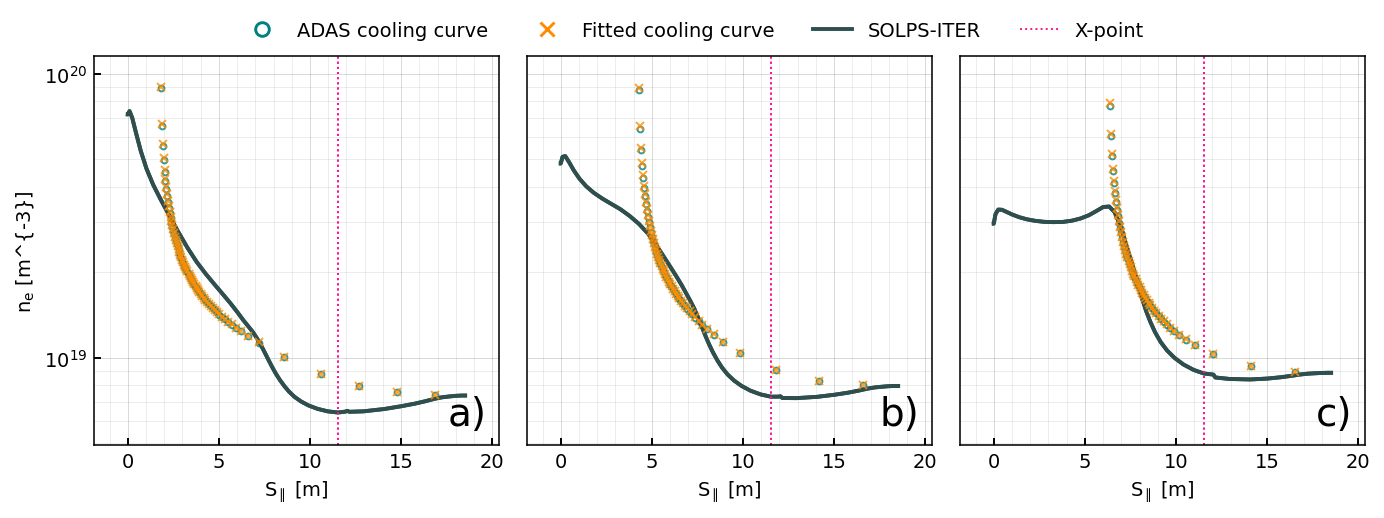

In [55]:
fig, axes = plt.subplots(1, 3, figsize = (10,3.5), sharey = True)

for study_no, study in enumerate(study_selection):
    for i, case in enumerate(case_selection):
        comp = comps_outer[study][case]
        dls = comp.dls
        spc = comp.solps  
        
        ax = axes[i]
        ax.plot(spc["Spar"], spc["ne"], label = study, **SOLPSstyle)  # SOLPS
        ax.plot(dls["Spar"][::5], dls["Ne"][::5], **DLSstyles[study], c = colors[study_no], alpha = 0.8)   # DLS
        ax.set_xlabel("$S_{\parallel}$ [m]")

        if i > 0:
            ax.tick_params(axis = "y", which = "both", left = False, labelleft = False)
            
        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        ax.set_yscale("log")
        make_xpoint(spc, ax)
        make_grid(ax)
        make_title(ax)
        
        
axes[0].set_ylabel("$n_e$ [m^{-3}]")
fig.tight_layout()
make_legend(fig)
plt.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\MASTU_dens.pdf", format = "pdf", bbox_inches = "tight")

## Impurity fraction

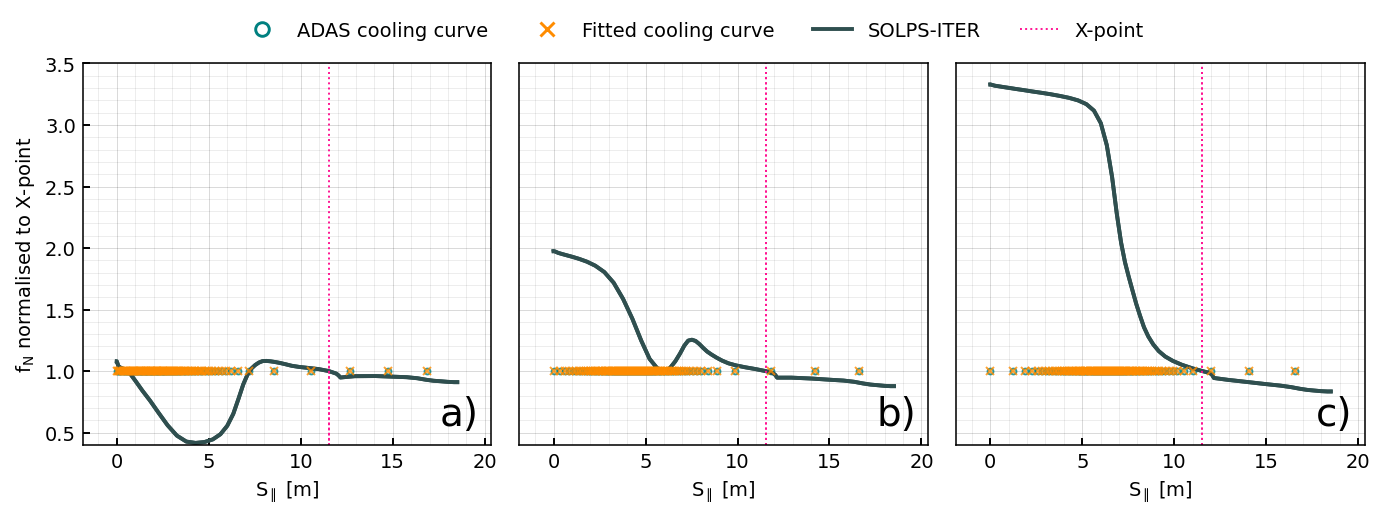

In [56]:
fig, axes = plt.subplots(1, 3, figsize = (10,3.5), sharey = True)

for study_no, study in enumerate(study_selection):
    for i, case in enumerate(case_selection):
        comp = comps_outer[study][case]
        dls = comp.dls
        spc = comp.solps  
        
        ax = axes[i]
        ax.plot(spc["Spar"],  spc["fN"] / spc[spc["Xpoint"] == 1]["fN"].values, label = study, **SOLPSstyle)  # SOLPS
        ax.plot(dls["Spar"][::5], dls["cz"][::5] / dls["cz"].iloc[-1] , **DLSstyles[study], c = colors[study_no], alpha = 0.8)   # DLS
        ax.set_xlabel("$S_{\parallel}$ [m]")

        if i > 0:
            ax.tick_params(axis = "y", which = "both", left = False, labelleft = False)
            
        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        # ax.set_yscale("log")
        make_xpoint(spc, ax)
        make_grid(ax)
        make_title(ax)
        ax.set_ylim(0.4, 3.5)
        
        
axes[0].set_ylabel("$f_N$ normalised to X-point")
fig.tight_layout()
make_legend(fig)
plt.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\MASTU_cz.pdf", format = "pdf", bbox_inches = "tight")

In [154]:
spc[spc["Xpoint"] == 1]["fN"]

14    0.15198
Name: fN, dtype: float64

## $n_e^{2} c_{z}$

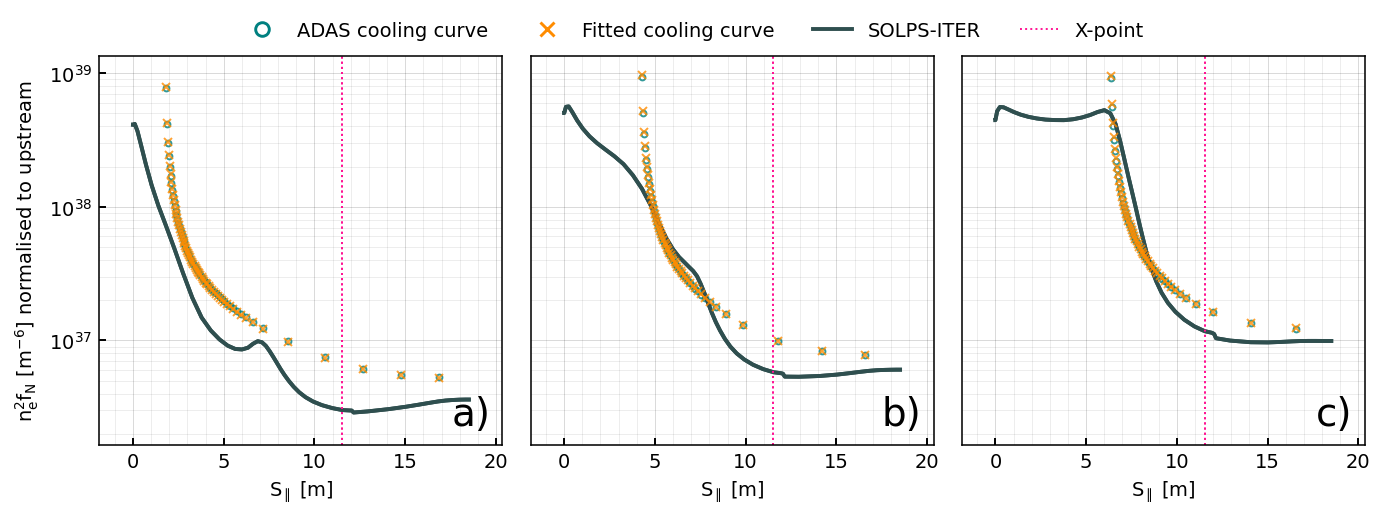

In [57]:
fig, axes = plt.subplots(1, 3, figsize = (10,3.5), sharey = True)

for study_no, study in enumerate(study_selection):
    for i, case in enumerate(case_selection):
        comp = comps_outer[study][case]
        dls = comp.dls
        spc = comp.solps  
        
        ax = axes[i]
        ax.plot(spc["Spar"], spc["ne"]**2 * spc["fN"], label = study, **SOLPSstyle)  # SOLPS
        ax.plot(dls["Spar"][::5], dls["Ne"][::5]**2 * dls["cz"][::5] , **DLSstyles[study], c = colors[study_no], alpha = 0.8)   # DLS
        ax.set_xlabel("$S_{\parallel}$ [m]")

        if i > 0:
            ax.tick_params(axis = "y", which = "both", left = False, labelleft = False)
            
        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        ax.set_yscale("log")
        make_xpoint(spc, ax)
        make_grid(ax)
        make_title(ax)
        
        
axes[0].set_ylabel("$n_e^2 f_N$ [$m^{-6}$] normalised to upstream")
fig.tight_layout()
make_legend(fig)
plt.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\MASTU_cz_ne_product.pdf", format = "pdf", bbox_inches = "tight")

## Heat flux

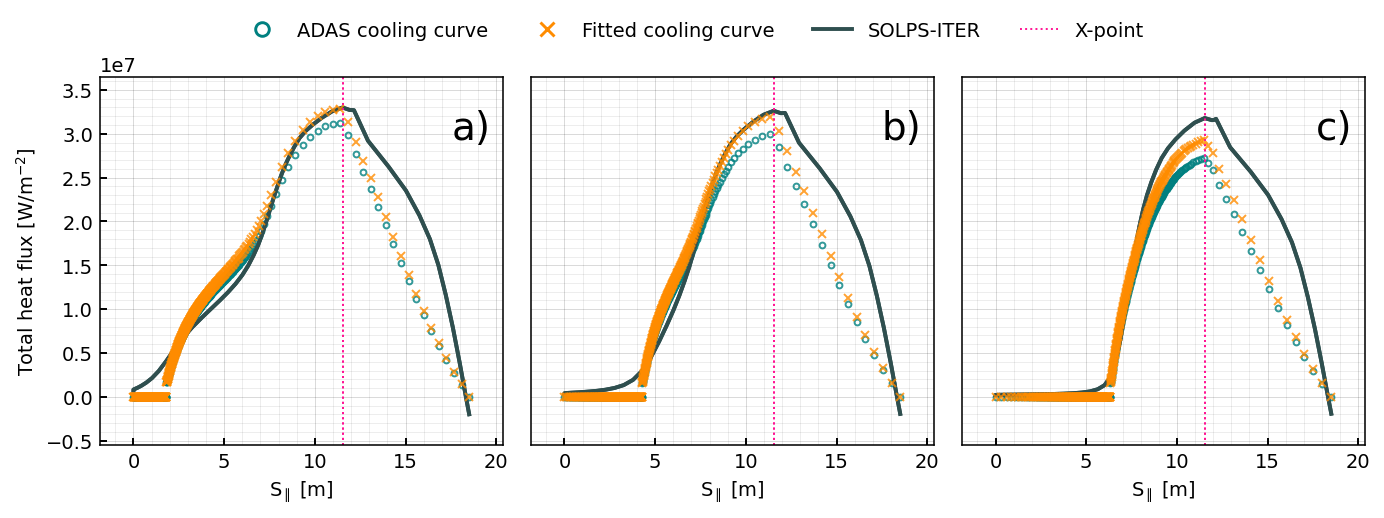

In [58]:
fig, axes = plt.subplots(1, 3, figsize = (10,3.5), sharey = True)

for study_no, study in enumerate(study_selection):
    for i, case in enumerate(case_selection):
        comp = comps_outer[study][case]
        dls = comp.dls
        spc = comp.solps  
        
        ax = axes[i]
        ax.plot(spc["Spar"], spc["fhx_total"], label = study, **SOLPSstyle)  # SOLPS
        ax.plot(dls["Spar"][::1], dls["qpar"][::1], **DLSstyles[study], c = colors[study_no], alpha = 0.8)   # DLS
        ax.set_xlabel("$S_{\parallel}$ [m]")

        if i > 0:
            ax.tick_params(axis = "y", which = "both", left = False, labelleft = False)
            
        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        make_grid(ax)
        make_xpoint(spc, ax)
        ax.set_title(figure_labels[i], loc = "right", y = 0.8, x = 0.97, fontsize = 20)
        
axes[0].set_ylabel("Total heat flux [$W/m^{-2}$]")
fig.tight_layout()
make_legend(fig)
plt.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\MASTU_hflux.pdf", format = "pdf", bbox_inches = "tight")

# Front scan comparison

## Extract SOLPS inputs

In [75]:
conditions = pd.DataFrame()
sepadd = 4
region = "outer_lower"

omkar = pd.read_csv(r"C:\Users\mikek\OneDrive\Project\DLS\digitised_plots\myatra_2023_fig7a.csv", header = None, names = ["seeding_rate", "cz"])
omkar["seeding_rate"] = omkar["seeding_rate"].round(1)

for name in store_slc.keys():
    slc = store_slc[name]
    
    df = slc.get_1d_poloidal_data(
        ["Te", "Ne", "Nn", "fN", "RN", "fC", "RC", "Btot", "fhx_total", "vol", "Rd+_exiz", "Rd+_mol"], 
        sepadd = sepadd, region = region, target_first = True)
    # df = df.iloc[:-1] ## Take out guards
    
   
    df["hf_par_tot"] = df["fhx_total"] / df["apar"]
    dfx = df[df["Xpoint"]==1].squeeze()
    
    conditions.loc[name, "seeding_rate"] = float(name.split("_")[1])
    conditions.loc[name, "Nu"] = df.iloc[-1]["Ne"]
    
    conditions.loc[name, "qpllu"] = dfx["hf_par_tot"]
    conditions.loc[name, "front_loc"] = slc.extract_front_pos(sepadd = sepadd, region = region, method = "qpar_total", threshold = 0.05)
    conditions.loc[name, "front_loc_Te5eV"] = slc.extract_front_pos(sepadd = sepadd, region = region, method = "Te", threshold = 5)
    
    ## Make radiation weighted average Cz 
    Lz = slc.extract_cooling_curve("N", region="outer_lower", sepadd = 4,order = 5)
    Qn = [Lz(T) for T in df["Te"]]  # Cooling rate in Wm3
    PN = df["RN"]  # Radiation power source in Wm-3
    Ptot = df["RN"] + df["RC"] + df["Rd+_exiz"] + df["Rd+_mol"]
    
    df_over5eV = df[df["Te"]>5]
    df_noneutrals = df[df["Nn"] < df["Ne"]*0.1]
    
    conditions.loc[name, "cz_omkar"] = omkar[omkar["seeding_rate"]== conditions.loc[name, "seeding_rate"]]["cz"].values[0]
    conditions.loc[name, "cz_volavg"] = (df["fN"] * df["vol"]).sum() / df["vol"].sum()
    conditions.loc[name, "cz_rad_volavg"] = (PN * df["vol"]).sum() / (Qn * df["Ne"]**2 * df["vol"]).sum()
    conditions.loc[name, "cz_radtot_volavg"] = (Ptot * df["vol"]).sum() / (Qn * df["Ne"]**2 * df["vol"]).sum()
    conditions.loc[name, "cz_over5eV_volavg"] = (df_over5eV["fN"] * df_over5eV["vol"]).sum() / df_over5eV["vol"].sum()
    conditions.loc[name, "cz_noneutrals_volavg"] = (df_noneutrals["fN"] * df_noneutrals["vol"]).sum() / df_noneutrals["vol"].sum()
    conditions.loc[name, "cz_xpoint"] = dfx["fN"]
    
for col in conditions.columns:
    if "cz" in col:
        conditions[col.replace("cz", "C")] = conditions[col]**(0.5) * conditions["Nu"] * conditions["qpllu"]**(-5/7)
        
for col in conditions.columns:
    if "cz" in col:        
        conditions[col.replace("cz", "Cnorm")] = conditions[col.replace("cz", "C")] / conditions[col.replace("cz", "C")].iloc[0]

# conditions_
# fig, ax = plt.subplots()
# ax.plot(conditions["cz_avg"], conditions["front_loc"])
display(conditions)

seeding_rate            Nu         qpllu  front_loc  front_loc_Te5eV  \
seed_1            1.0  7.877071e+18  3.303052e+07   0.000000         0.097290   
seed_2            2.0  7.349315e+18  3.270975e+07   0.710387         1.395744   
seed_3            3.0  7.479204e+18  3.250412e+07   2.762228         3.268734   
seed_4            4.0  7.945203e+18  3.235036e+07   3.268734         4.285125   
seed_5            5.0  7.890574e+18  3.242525e+07   4.285125         4.769180   
seed_6            6.0  8.011308e+18  3.221669e+07   4.769180         5.221884   
seed_7            7.0  8.155867e+18  3.213190e+07   4.769180         5.635237   
seed_8            8.0  8.294202e+18  3.195008e+07   5.221884         6.005345   
seed_9            9.0  8.419528e+18  3.186686e+07   5.635237         6.005345   
seed_10          10.0  8.840356e+18  3.155445e+07   6.005345         6.621119   

         cz_omkar  cz_volavg  cz_rad_volavg  cz_radtot_volavg  \
seed_1   0.034447   0.028194       0.004469         -0.011591   
seed_2   0.085804   0.060617       0.044588          0.025545   
seed_3   0.154071   0.128202       0.121172          0.100032   
seed_4   0.183507   0.140839       0.125345          0.103889   
seed_5   0.201044   0.197478       0.183531          0.159888   
seed_6   0.214196   0.224771       0.202753          0.178104   
seed_7   0.222338   0.248150       0.218010          0.192662   
seed_8   0.228601   0.270394       0.229613          0.203627   
seed_9   0.232985   0.286625       0.237569          0.210977   
seed_10  0.236743   0.318499       0.246684          0.219637   

         cz_over5eV_volavg  ...  C_over5eV_volavg  C_noneutrals_volavg  \
seed_1            0.028682  ...      5.682212e+12         5.682212e+12   
seed_2            0.059009  ...      7.657390e+12         7.663781e+12   
seed_3            0.106983  ...      1.054002e+13         1.078092e+13   
seed_4            0.110156  ...      1.140010e+13         1.166218e+13   
seed_5            0.139526  ...      1.272095e+13         1.318527e+13   
seed_6            0.148181  ...      1.337164e+13         1.391903e+13   
seed_7            0.153181  ...      1.386678e+13         1.445288e+13   
seed_8            0.156382  ...      1.430641e+13         1.490956e+13   
seed_9            0.162244  ...      1.481987e+13         1.553099e+13   
seed_10           0.161577  ...      1.563824e+13         1.629243e+13   

             C_xpoint  Cnorm_omkar  Cnorm_volavg  Cnorm_rad_volavg  \
seed_1   7.716446e+12     1.000000      1.000000          1.000000   
seed_2   8.456672e+12     1.482819      1.377610          2.967792   
seed_3   1.025926e+13     2.031236      2.048052          5.001360   
seed_4   1.124898e+13     2.362910      2.288108          5.422016   
seed_5   1.205304e+13     2.452179      2.686338          6.505020   
seed_6   1.264247e+13     2.581721      2.923259          6.973871   
seed_7   1.312384e+13     2.682839      3.132847          7.375870   
seed_8   1.360609e+13     2.777741      3.339220          7.729250   
seed_9   1.396545e+13     2.851930      3.496436          7.995701   
seed_10  1.505027e+13     3.039846      3.897275          8.615294   

         Cnorm_radtot_volavg  Cnorm_over5eV_volavg  Cnorm_noneutrals_volavg  \
seed_1                   NaN              1.000000                 1.000000   
seed_2                   NaN              1.347607                 1.348732   
seed_3                   NaN              1.854915                 1.897310   
seed_4                   NaN              2.006279                 2.052401   
seed_5                   NaN              2.238732                 2.320446   
seed_6                   NaN              2.353246                 2.449580   
seed_7                   NaN              2.440385                 2.543531   
seed_8                   NaN              2.517753                 2.623901   
seed_9                   NaN              2.608116                 2.733265   
seed_10                  

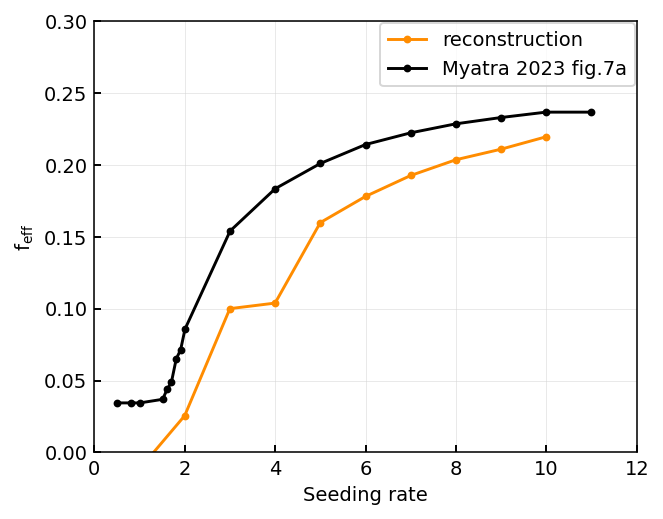

In [44]:
fig, ax = plt.subplots()
omkar = pd.read_csv(r"C:\Users\mikek\OneDrive\Project\DLS\digitised_plots\myatra_2023_fig7a.csv", header = None, names = ["seeding_rate", "cz"])

ax.plot(conditions["seeding_rate"], conditions["cz_radtot_volavg"], c = "darkorange", marker = "o", ms = 3, lw = 1.5, label = "reconstruction")
ax.plot(omkar["seeding_rate"], omkar["cz"], c = "k", marker = "o", ms = 3, lw = 1.5, label = "Myatra 2023 fig.7a")
ax.set_ylim(0,0.3)
ax.set_xlim(0, 12)
ax.set_xlabel("Seeding rate")
ax.set_ylabel("$f_{eff}$")
ax.legend()

Text(0.5, 1.0, 'Impact of cz definition on front movement')

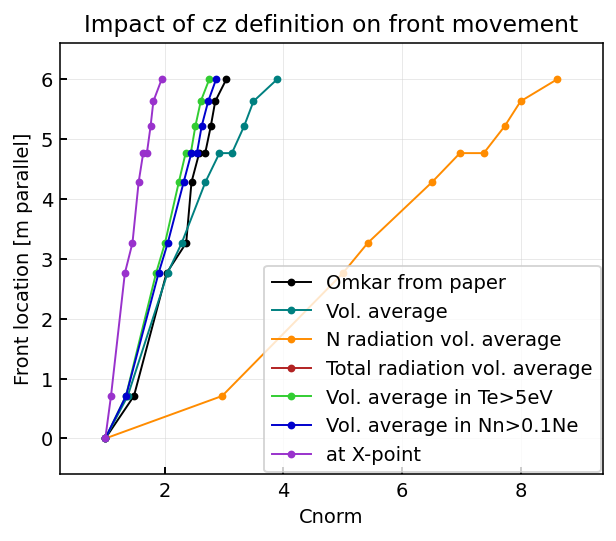

In [99]:
fig, ax = plt.subplots()
x_choice = "Cnorm"
style = dict(marker = "o", ms = 3, lw = 1)
ax.plot(conditions[f"{x_choice}_omkar"], conditions["front_loc"], **style, c = "k", label = "Omkar from paper")
ax.plot(conditions[f"{x_choice}_volavg"], conditions["front_loc"], **style, label = "Vol. average")
ax.plot(conditions[f"{x_choice}_rad_volavg"], conditions["front_loc"], **style, label = "N radiation vol. average")
ax.plot(conditions[f"{x_choice}_radtot_volavg"], conditions["front_loc"], **style, label = "Total radiation vol. average")
ax.plot(conditions[f"{x_choice}_over5eV_volavg"], conditions["front_loc"], **style, label = "Vol. average in Te>5eV")
ax.plot(conditions[f"{x_choice}_noneutrals_volavg"], conditions["front_loc"], **style, label = "Vol. average in Nn>0.1Ne")
ax.plot(conditions[f"{x_choice}_xpoint"], conditions["front_loc"], **style, label = "at X-point")
ax.set_xlabel("C" if x_choice == "C" else "Cnorm")
ax.set_ylabel("Front location [m parallel]")
ax.legend()
ax.set_title("Impact of cz definition on front movement")

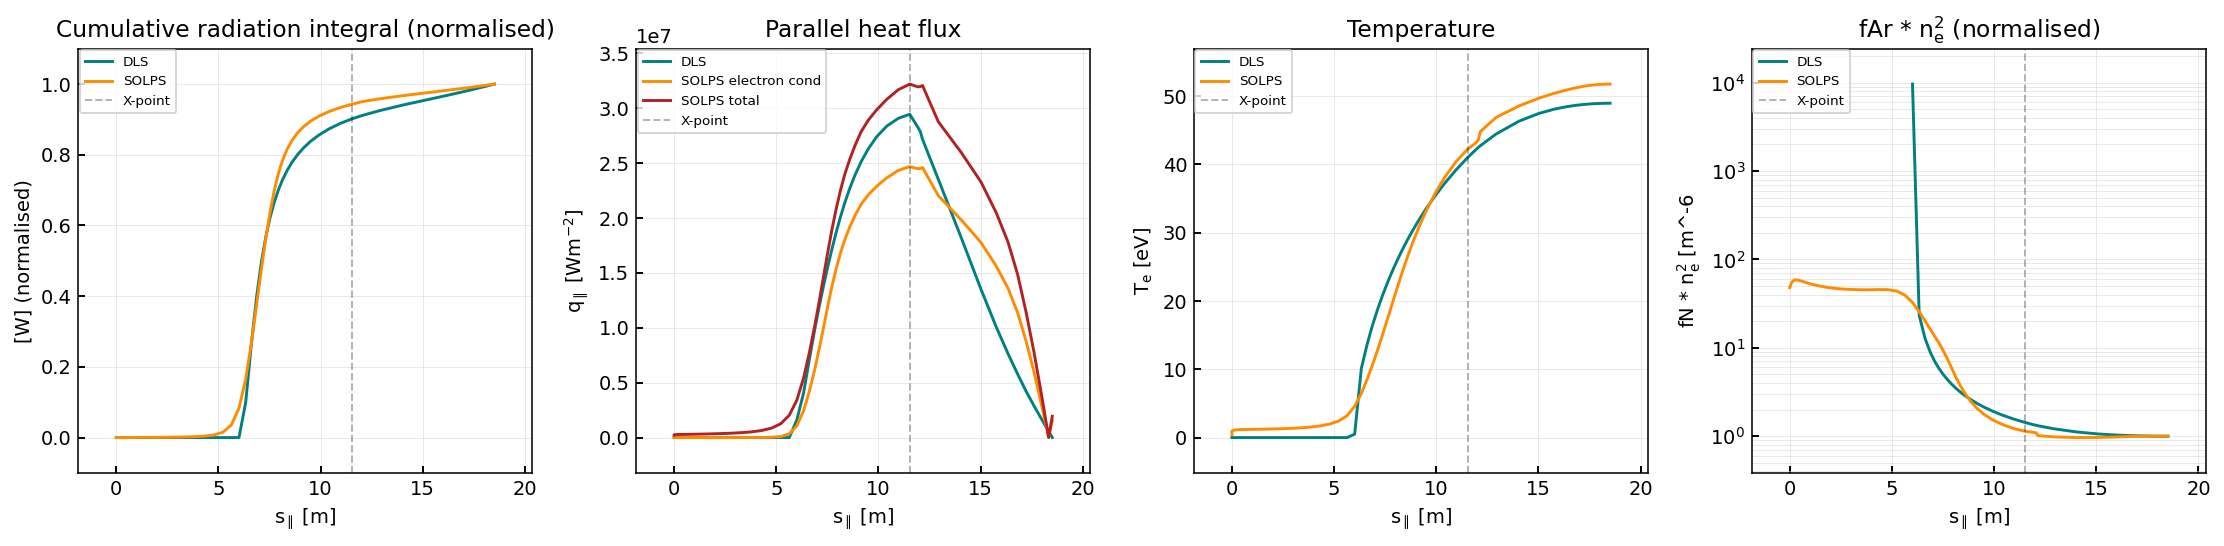

In [160]:
comps["cz_ne_effects"]["seed_8"].plot(["Cumrad", "qpar", "Te", "cz"], normalise_radiation = True , radiation_per_area= False)

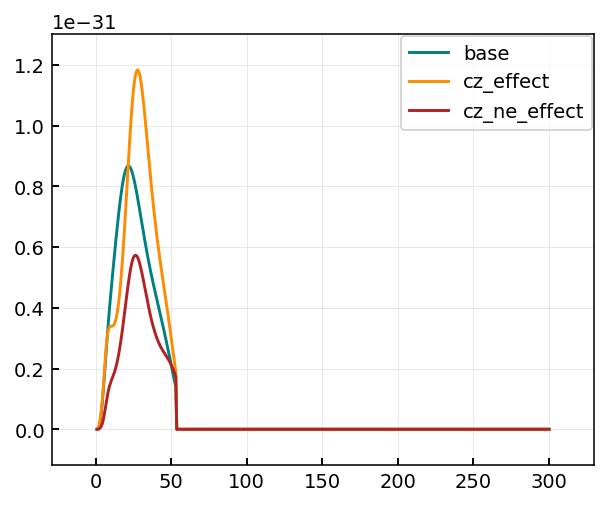

In [48]:
funs = {}
funs["base"] = slc.extract_cooling_curve("N", region, sepadd = sepadd, plot = False, cz_effect = False, ne_effect = False)
funs["cz_effect"] = slc.extract_cooling_curve("N", region, sepadd = sepadd, plot = False, cz_effect = True, ne_effect = False)
funs["cz_ne_effect"] = slc.extract_cooling_curve("N", region, sepadd = sepadd, plot = False, cz_effect = True, ne_effect = True)

temp = np.linspace(1,300,500)

fig, ax = plt.subplots()
for fun in funs:
    ax.plot(temp, [funs[fun](t) for t in temp], label = fun)
ax.legend()

## Compare results

### Analysis of SOLPS cz definitions

### Compile DLS results

In [80]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

dls_cases = {}
dls_results = {}   # study results

for study_name, study in outputs_outer.items():
    dls_cases[study_name] = {}
    
    for _, run_name in enumerate(conditions.index):
        if "seed_1" not in run_name:
            dls_cases[study_name][run_name] = DLScase(outputs_outer[study_name][run_name])   
        
    df = pd.DataFrame()
    for run_name, dls in dls_cases[study_name].items():
        out = outputs_outer[study_name][run_name]
        comp = comps_outer[study_name][run_name]
        df.loc[run_name, "front_loc"] = conditions.loc[run_name, "front_loc"]
        df.loc[run_name, "BfBx"] = dls.data["Btot"][0] / dls.stats["Bx"]
        df.loc[run_name, "50pc_rad_loc"] = comp.get_front_location(mode = "dls", threshold = 0.5)
        conditions.loc[run_name, "50pc_rad_loc"] = comp.get_front_location(mode = "solps", threshold = 0.5)
        df.loc[run_name, "cz_avg"] = dls.stats["cvar"]
        
        
    df["Nu"] = conditions["Nu"].copy()
    df["qpllu"] = conditions["qpllu"].copy()
    
    for col in conditions.columns:
        if "cz" in col:
            conditions[col.replace("cz", "C")] = conditions[col]**(0.5) * conditions["Nu"] * conditions["qpllu"]**(-5/7)
            conditions[col.replace("cz", "Cnorm")] = conditions[col.replace("cz", "C")] / conditions[col.replace("cz", "C")].iloc[0]
  
    df["C"] = df["Nu"] * df["qpllu"]**(-5/7) * df["cz_avg"]**(0.5)
    df["Cnorm"] = df["C"] / df["C"].iloc[0]
    
    dls_results[study_name] = df

# dls_results["narrowcurve"]

In [81]:
dls_results

{'adas_curve':         front_loc      BfBx  50pc_rad_loc    cz_avg            Nu  \
 seed_2   0.710387  0.403887      2.277491  0.084002  7.349315e+18   
 seed_3   2.762228  0.403882      4.129809  0.106117  7.479204e+18   
 seed_4   3.268734  0.403889      4.585681  0.101069  7.945203e+18   
 seed_5   4.285125  0.403872      5.491810  0.122224  7.890574e+18   
 seed_6   4.769180  0.403890      5.929256  0.130362  8.011308e+18   
 seed_7   4.769180  0.403890      5.931030  0.125390  8.155867e+18   
 seed_8   5.221884  0.403872      6.344735  0.132891  8.294202e+18   
 seed_9   5.635237  0.403889      6.729927  0.141808  8.419528e+18   
 
                qpllu             C     Cnorm  
 seed_2  3.270975e+07  9.136206e+12  1.000000  
 seed_3  3.250412e+07  1.049729e+13  1.148977  
 seed_4  3.235036e+07  1.091980e+13  1.195222  
 seed_5  3.242525e+07  1.190612e+13  1.303180  
 seed_6  3.221669e+07  1.254193e+13  1.372772  
 seed_7  3.213190e+07  1.254599e+13  1.373217  
 seed_8  3.195008e

In [79]:
outputs_outer["adas_curve"].keys()

dict_keys(['seed_2', 'seed_3', 'seed_4', 'seed_5', 'seed_6', 'seed_7', 'seed_8', 'seed_9', 'seed_10'])

In [83]:
conditions.keys()

Index(['seeding_rate', 'Nu', 'qpllu', 'front_loc', 'front_loc_Te5eV',
       'cz_omkar', 'cz_volavg', 'cz_rad_volavg', 'cz_radtot_volavg',
       'cz_over5eV_volavg', 'cz_noneutrals_volavg', 'cz_xpoint', 'C_omkar',
       'C_volavg', 'C_rad_volavg', 'C_radtot_volavg', 'C_over5eV_volavg',
       'C_noneutrals_volavg', 'C_xpoint', 'Cnorm_omkar', 'Cnorm_volavg',
       'Cnorm_rad_volavg', 'Cnorm_radtot_volavg', 'Cnorm_over5eV_volavg',
       'Cnorm_noneutrals_volavg', 'Cnorm_xpoint', '50pc_rad_loc'],
      dtype='object')

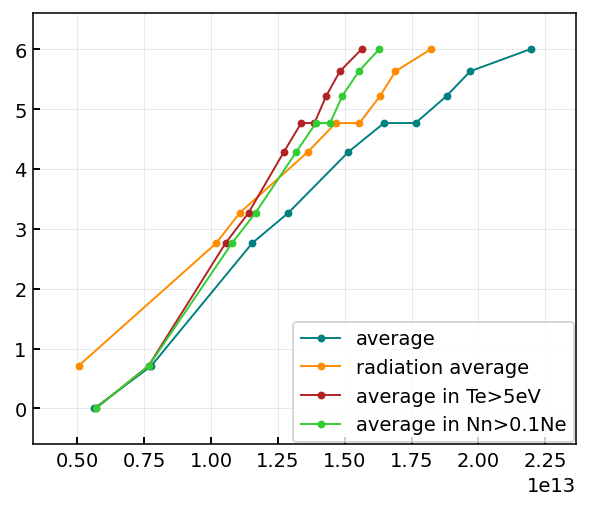

In [90]:
fig, ax = plt.subplots()
ax.plot(conditions["C_volavg"], conditions["front_loc"], **style, label = "average")
ax.plot(conditions["C_radtot_volavg"], conditions["front_loc"], **style, label = "radiation average")
ax.plot(conditions["C_over5eV_volavg"], conditions["front_loc"], **style, label = "average in Te>5eV")
ax.plot(conditions["C_noneutrals_volavg"], conditions["front_loc"], **style, label = "average in Nn>0.1Ne")
ax.legend()

In [95]:
conditions.columns

Index(['seeding_rate', 'Nu', 'qpllu', 'front_loc', 'cz_volavg',
       'cz_rad_volavg', 'cz_radtot_volavg', 'cz_over5eV_volavg',
       'cz_noneutrals_volavg', 'cz_xpoint', 'C_volavg', 'C_rad_volavg',
       'C_radtot_volavg', 'C_over5eV_volavg', 'C_noneutrals_volavg',
       'C_xpoint', 'Cnorm_volavg', 'Cnorm_rad_volavg', 'Cnorm_radtot_volavg',
       'Cnorm_over5eV_volavg', 'Cnorm_noneutrals_volavg', 'Cnorm_xpoint',
       '50pc_rad_loc'],
      dtype='object')

In [102]:
omkar = pd.read_csv(r"C:\Users\mikek\OneDrive\Project\DLS\digitised_plots\myatra_2023_fig7a.csv", header = None, names = ["seeding_rate", "cz"])

omkar["seeding_rate"] = omkar["seeding_rate"].round(1)
omkar_filter = omkar[omkar["seeding_rate"].isin(conditions["seeding_rate"])]
conditions["cz_omkar"] = omkar_filter["cz"].values

In [92]:
omkar_Cnorm_DLS = pd.read_csv(r"C:\Users\mikek\OneDrive\Project\DLS\digitised_plots\myatra_2023_fig8a_DLS_nonlinear.csv", header = None, names = ["Cnorm", "front_loc"])
omkar_Cnorm_SOLPS = pd.read_csv(r"C:\Users\mikek\OneDrive\Project\DLS\digitised_plots\myatra_2023_fig8a_Te5eV.csv", header = None, names = ["Cnorm", "front_loc"])

In [102]:
conditions.keys()

Index(['seeding_rate', 'Nu', 'qpllu', 'front_loc', 'front_loc_Te5eV',
       'cz_omkar', 'cz_volavg', 'cz_rad_volavg', 'cz_radtot_volavg',
       'cz_over5eV_volavg', 'cz_noneutrals_volavg', 'cz_xpoint', 'C_omkar',
       'C_volavg', 'C_rad_volavg', 'C_radtot_volavg', 'C_over5eV_volavg',
       'C_noneutrals_volavg', 'C_xpoint', 'Cnorm_omkar', 'Cnorm_volavg',
       'Cnorm_rad_volavg', 'Cnorm_radtot_volavg', 'Cnorm_over5eV_volavg',
       'Cnorm_noneutrals_volavg', 'Cnorm_xpoint', '50pc_rad_loc'],
      dtype='object')

Text(0, 0.5, 'Front position [m]')

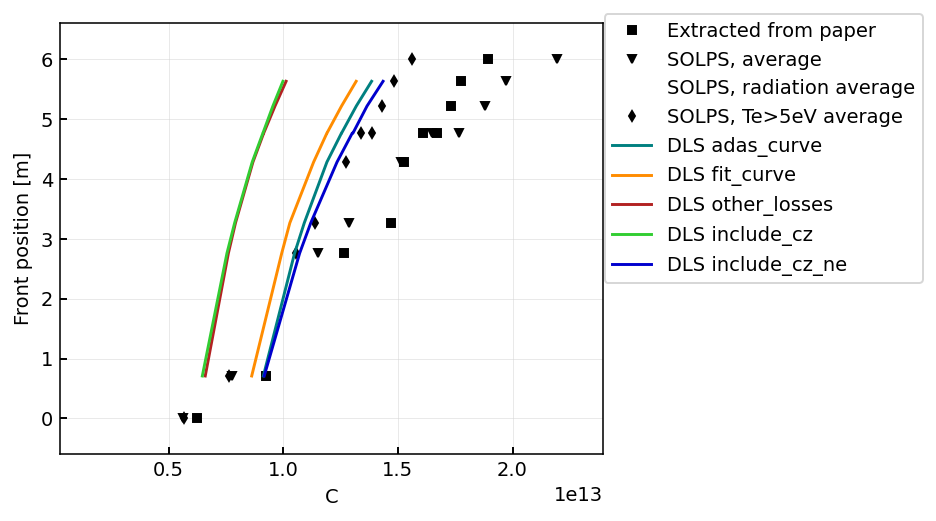

In [105]:
fig, ax = plt.subplots()
x_choice = "C"


front_style = dict(lw = 0, marker = "o", alpha = 0.3, ms = 2)

solps_style = dict(lw = 0, c = "k", alpha = 1, ms = 4)
ax.plot(conditions[f"{x_choice}_omkar"], conditions["front_loc"], **solps_style, marker = "s", label = "Extracted from paper")
ax.plot(conditions[f"{x_choice}_volavg"], conditions["front_loc"], **solps_style, marker = "v", label = "SOLPS, average")
ax.plot(conditions[f"{x_choice}_rad_volavg"], conditions["front_loc"], **solps_style, label = "SOLPS, radiation average")
ax.plot(conditions[f"{x_choice}_over5eV_volavg"], conditions["front_loc"], **solps_style, marker = "d", label = "SOLPS, Te>5eV average")
# ax.plot(conditions[f"{x_choice}_xpoint"], conditions["front_loc"], **solps_style, marker = "o", label = "SOLPS, X-point")
# ax.plot(conditions[f"{x_choice}_noneutrals_avg"], conditions["front_loc"], label = "SOLPS")

for i, study_name in enumerate(dls_results.keys()):
    df = dls_results[study_name]
    ax.plot(df[x_choice], df["front_loc"], label = f"DLS {study_name}", c = colors[i])
    # ax.plot(df[x_choice], df["50pc_rad_loc"], c = colors[i], **front_style)
    # ax.plot(df[x_choice], df["50pc_rad_loc"], color = "darkorange", lw = 0, marker = "o", ms = 3)
    
# ax.plot(omkar_Cnorm_DLS["Cnorm"], omkar_Cnorm_DLS["front_loc"]*0.5, label = "Omkar DLS", c = "k", lw = "2", ls = "--",  ms = 3)
# ax.plot(omkar_Cnorm_SOLPS["Cnorm"], omkar_Cnorm_SOLPS["front_loc"]*0.5, label = "Omkar SOLPS", **solps_style, marker = "d")
fig.legend(loc = "upper left", bbox_to_anchor=(0.9,0.9))

ax.set_xlabel(x_choice)
ax.set_ylabel("Front position [m]")

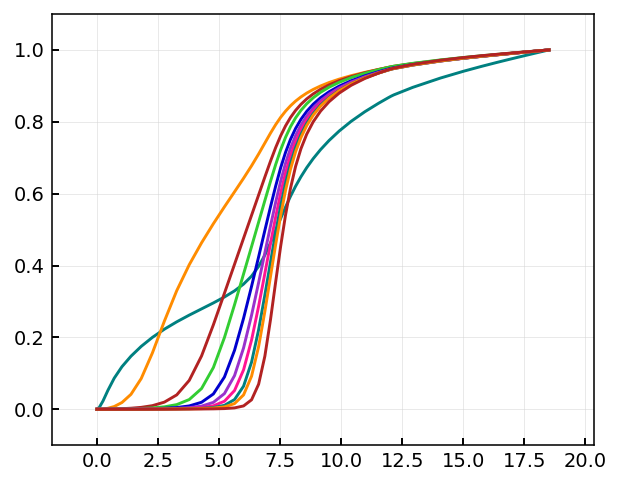

In [136]:
fig, ax = plt.subplots()

for name, comp in comps.items():
    ax.plot(comp.solps["Spar"], comp.solps["Prad_per_area_cum_norm"], label = name)    

In [128]:
comp = comps["seed_4"]
comp.get_front_location(mode = "solps", threshold = 0.2)

array(1.22433891)

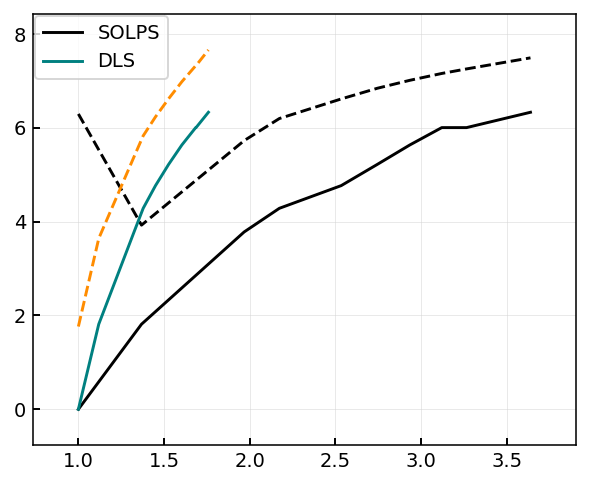